In [1]:
import os
import sys
import math
import csv
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics

import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils import data
from torch.utils.data import (
    DataLoader,
    RandomSampler,
    SequentialSampler,
    TensorDataset,
    WeightedRandomSampler,
    random_split
)
import torchvision
from torchvision.datasets import mnist

from torch.optim.lr_scheduler import CosineAnnealingLR
from warmup_scheduler import GradualWarmupScheduler

# 设置项目根目录
project_root = "C:/Users/Admin/Mouse"  # 替换为您的项目根目录路径
datautils_path = os.path.join(project_root, 'datautils')
model_path = os.path.join(project_root, 'model')

# 添加自定义模块路径
sys.path.extend([datautils_path, model_path])

# 导入自定义模块
from data_utils import load_mouse_data, process_mouse_data
from resnet_mouse import  BasicBlock1D, ResNet1D,resnet50_1d
from mouse_traj_classification import MouseNeuralNetwork, MouseNeuralNetwork2
from new_optim import SWATS

# 获取当前工作目录（可选）
pwd = os.getcwd()
# print(pwd)


In [2]:
import random
random_seed = 3407
# set the random seed for pytorch
torch.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# set the random seed for "random"
random.seed(random_seed)

# set the random seed for numpy
np.random.seed(random_seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# 设置用户ID和窗口大小
user_id = 7
window_size = 100


# 加载和处理数据
X, label = process_mouse_data(
    f'D:/论文数据/mouse/data/processed_data_user{user_id}/positive_samples_user{user_id}_{window_size}.json',
    f'D:/论文数据/mouse/data/processed_data_user{user_id}/negative_samples_user{user_id}_{window_size}.json'
)
# 计算数据集划分长度

train_len = math.floor(len(X)*0.7)
test_len = len(X) - train_len


In [4]:
# 创建整体数据集
dataset = torch.utils.data.TensorDataset(
    X.float(),  # 确保输入数据是float类型
    label.long() # 确保标签是long类型
)

# 统计正负样本数量
pos_indices = (label == 0)  # 正样本索引
neg_indices = (label == 1)  # 负样本索引
pos_data = X[pos_indices]
neg_data = X[neg_indices]
pos_labels = label[pos_indices]
neg_labels = label[neg_indices]


# 计算正负样本中训练集和测试集的数量（70%训练，30%测试）
n_pos = len(pos_data)
n_neg = len(neg_data)

train_pos_len = math.floor(n_pos * 0.7)
test_pos_len = n_pos - train_pos_len

train_neg_len = math.floor(n_neg * 0.7)
test_neg_len = n_neg - train_neg_len

# 随机打乱正负样本索引
pos_shuffle = torch.randperm(n_pos)
neg_shuffle = torch.randperm(n_neg)

# 划分正样本：训练和测试
train_pos = pos_data[pos_shuffle[:train_pos_len]]
test_pos = pos_data[pos_shuffle[train_pos_len:]]

train_pos_labels = pos_labels[pos_shuffle[:train_pos_len]]
test_pos_labels = pos_labels[pos_shuffle[train_pos_len:]]

# 划分负样本：训练和测试
train_neg = neg_data[neg_shuffle[:train_neg_len]]
test_neg = neg_data[neg_shuffle[train_neg_len:]]

train_neg_labels = neg_labels[neg_shuffle[:train_neg_len]]
test_neg_labels = neg_labels[neg_shuffle[train_neg_len:]]

# 合并正负样本到训练集和测试集
train_data = torch.cat([train_pos, train_neg])
test_data = torch.cat([test_pos, test_neg])

train_labels = torch.cat([train_pos_labels, train_neg_labels])
test_labels = torch.cat([test_pos_labels, test_neg_labels])

# 随机打乱训练集和测试集数据
train_indices = torch.randperm(len(train_data))
test_indices = torch.randperm(len(test_data))

train_data = train_data[train_indices]
train_labels = train_labels[train_indices]

test_data = test_data[test_indices]
test_labels = test_labels[test_indices]

# 创建训练和测试数据集
train_dataset = torch.utils.data.TensorDataset(train_data, train_labels)
test_dataset = torch.utils.data.TensorDataset(test_data, test_labels)
# print(len(test_dataset))
# 打印划分后的分布信息
print("\nDistribution after split:")
print("Training set:")
print(f"Positive: {(train_labels == 0).sum().item()}, Negative: {(train_labels == 1).sum().item()}")
print("Test set:")
print(f"Positive: {(test_labels == 0).sum().item()}, Negative: {(test_labels == 1).sum().item()}")



Distribution after split:
Training set:
Positive: 6612, Negative: 1321
Test set:
Positive: 2834, Negative: 567


In [5]:
# # 计算类别权重
# class_count = [len(label[label == t]) for t in torch.unique(label)]
# weights = [1.0 if t == 1 else 1.0 for t in label.cpu().numpy()]  # 转换为numpy数组
# sample_weights = torch.FloatTensor(weights)
# sampler = WeightedRandomSampler(sample_weights, len(sample_weights))


# 设置合适的batch_size
# train_batch_size = 64  # 较小的batch_size，可以更好地训练  
# test_batch_size = 64  # 测试集也可以用大一点的batch_size

# 创建数据加载器
# X_train_loader = torch.utils.data.DataLoader(
#     train_dataset, 
#     batch_size=train_batch_size,
#     shuffle=True,
#     drop_last=False,
#     pin_memory=True
# )


# X_test_loader = torch.utils.data.DataLoader(
#     test_dataset, 
#     batch_size=test_batch_size,
#     shuffle=False,
#     drop_last=False,
#     pin_memory=True
# )

In [6]:
# 保存各个数据加载器
# 创建目录
import pickle
# 创建目录
base_path = f'D:/论文数据/mouse/data_pkl/processed_data_user{user_id}'
os.makedirs(base_path, exist_ok=True)  # exist_ok=True 表示如果目录已存在则不报错

# 指定保存路径
train_dataset_path = f'{base_path}/train_dataset_user{user_id}_{window_size}.pkl'
test_dataset_path = f'{base_path}/test_dataset_user{user_id}_{window_size}.pkl'

with open(train_dataset_path, 'wb') as f:
    torch.save(train_dataset, f, pickle_module=pickle)

with open(test_dataset_path, 'wb') as f:
    torch.save(test_dataset, f, pickle_module=pickle)

In [7]:

# 加载时
with open(train_dataset_path, 'rb') as f:
    train_dataset = torch.load(f, pickle_module=pickle)

with open(test_dataset_path, 'rb') as f:
    test_dataset = torch.load(f, pickle_module=pickle)

# 重新创建 DataLoader
X_train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
X_test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

In [8]:
# 首先从数据中获取序列长度和特征数量
sequence_length = X.shape[2]  # 序列长度
num_features = X.shape[1]     # 特征数量

# 修改模型初始化部分
model = MouseNeuralNetwork2(length_single_mouse_traj=window_size)
model = model.to(device)  # 将模型移动到指定设备

max_lr = 1e-4
min_lr = 1e-7
warmup_epochs = 10
total_epochs = 50


# 3. 初始化优化器 (在模型移动到GPU之后初始化优化器)
optimizer = SWATS(model.parameters(), lr=1e-3)
optim_SGD = torch.optim.SGD(
    model.parameters(), 
    lr=1e-4, 
    momentum=0.80, 
    dampening=0, 
    weight_decay=1e-3, 
    nesterov=False
)

optim_ADAM = torch.optim.Adam(
    model.parameters(), 
    lr=min_lr,
    weight_decay=1e-3
)

# After warmup, use cosine annealing for (total_epochs - warmup_epochs) steps
cosine_scheduler = CosineAnnealingLR(optim_ADAM, T_max=(total_epochs - warmup_epochs), eta_min=min_lr)

# The multiplier is how much you multiply the initial LR to get the target LR at the end of warmup.
# If initial LR = 1e-7 and we want 1e-3 after warmup:
# multiplier = (desired_lr_after_warmup) / (initial_lr) = 1e-3 / 1e-7 = 10,000
multiplier = max_lr / min_lr

warmup_scheduler = GradualWarmupScheduler(optim_ADAM, multiplier=multiplier, total_epoch=warmup_epochs, after_scheduler=cosine_scheduler)

# 检查第一个batch的数据
for batch_data, batch_labels in X_train_loader:
    print("数据维度:", batch_data.shape)
    print("标签维度:", batch_labels.shape)
    print("数据类型:", batch_data.dtype)
    print("标签类型:", batch_labels.dtype)
    break

数据维度: torch.Size([128, 1, 100])
标签维度: torch.Size([128])
数据类型: torch.float32
标签类型: torch.float32


In [9]:
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
import torch
import torch.nn as nn
from IPython.display import clear_output
import matplotlib.pyplot as plt
import os

def train_ADAM(model, X_train_loader, optimizer=None, scheduler=None, epoch=300, user_id=None, window_size=None):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    loss_function = nn.CrossEntropyLoss()
    model = model.to(device)
    loss_function = loss_function.to(device)
    
    losslist = []
    correctlist = []
    train_correctlist = []
    
    writer = SummaryWriter('/root/tf-logs')
    pbar = tqdm(total=epoch, desc='Training Progress')
    
    for i in range(epoch):
        model.train()
        totalloss = 0
        correct = 0
        total = 0
        num_batches = 0
        
        for data in X_train_loader:
            X, label = data
            X = X.float().to(device)
            label = label.long().to(device)
            
            optimizer.zero_grad()
            pred = model(X).squeeze()
            loss = loss_function(pred, label)
           
            totalloss += loss.item()
            num_batches += 1
            _, pred_id = torch.max(pred, dim=1)
            correct += (pred_id == label).sum().cpu().detach().numpy()
            total += label.size(0)
            
            loss.backward()
            optimizer.step()
        
        if scheduler:
            scheduler.step()
        
        current_lr = scheduler.get_last_lr()[0]
        print(f"Epoch {i+1}: LR = {current_lr:.8f}")

        train_acc = correct / total
        avg_loss = totalloss / num_batches
        losslist.append(avg_loss)
        
        pbar.update(1)
        pbar.set_postfix({
            'loss': f'{avg_loss:.4f}',
            'acc': f'{train_acc:.4f}'
        })
        
        if (i + 1) % 100 == 0:
            print(f'Epoch {i+1}/{epoch} - Loss: {avg_loss:.4f}, Accuracy: {train_acc:.4f}')
            correctlist.append(train_acc)
            train_correctlist.append(train_acc)
            writer.add_scalar('Training loss', avg_loss, i)
            writer.add_scalar('Training accuracy', train_acc, i)
    
    pbar.close()
    writer.close()
    
    # 绘制损失曲线
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, epoch + 1), losslist, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')  
    plt.title(f'user_{user_id} window{window_size}+Resnet Training Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    
    # 创建保存路径（如果不存在）
    save_path = 'D:/论文数据/mouse/model_pt/resnet/Loss_log'
    os.makedirs(save_path, exist_ok=True)
    
    # 保存图像，文件名与title一致
    plt.savefig(os.path.join(save_path, f'user_{user_id} window{window_size}+Resnet Training Loss.png'))
    plt.show()
    
    return optimizer, epoch, losslist, correctlist, train_correctlist

Training Progress:   2%|▊                                      | 1/50 [00:01<00:52,  1.08s/it, loss=0.7249, acc=0.4950]

Epoch 1: LR = 0.00001009


Training Progress:   4%|█▌                                     | 2/50 [00:02<00:55,  1.15s/it, loss=0.5071, acc=0.7747]

Epoch 2: LR = 0.00002008


Training Progress:   6%|██▎                                    | 3/50 [00:03<01:00,  1.28s/it, loss=0.3416, acc=0.8637]

Epoch 3: LR = 0.00003007


Training Progress:   8%|███                                    | 4/50 [00:05<01:00,  1.31s/it, loss=0.2243, acc=0.9142]

Epoch 4: LR = 0.00004006


Training Progress:  10%|███▉                                   | 5/50 [00:06<00:59,  1.33s/it, loss=0.0791, acc=0.9824]

Epoch 5: LR = 0.00005005


Training Progress:  12%|████▋                                  | 6/50 [00:07<00:59,  1.35s/it, loss=0.0303, acc=0.9941]

Epoch 6: LR = 0.00006004


Training Progress:  14%|█████▍                                 | 7/50 [00:09<00:58,  1.37s/it, loss=0.0420, acc=0.9871]

Epoch 7: LR = 0.00007003


Training Progress:  16%|██████▏                                | 8/50 [00:10<00:56,  1.36s/it, loss=0.0896, acc=0.9670]

Epoch 8: LR = 0.00008002


Training Progress:  18%|███████                                | 9/50 [00:11<00:55,  1.36s/it, loss=0.0848, acc=0.9704]

Epoch 9: LR = 0.00009001


Training Progress:  20%|███████▌                              | 10/50 [00:13<00:54,  1.36s/it, loss=0.0559, acc=0.9810]

Epoch 10: LR = 0.00010000


D:\conda\envs\mouse\lib\site-packages\torch\optim\lr_scheduler.py:1063: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  _warn_get_lr_called_within_step(self)
Training Progress:  22%|████████▎                             | 11/50 [00:14<00:53,  1.38s/it, loss=0.0181, acc=0.9943]

Epoch 11: LR = 0.00010000


Training Progress:  24%|█████████                             | 12/50 [00:16<00:51,  1.36s/it, loss=0.0256, acc=0.9913]

Epoch 12: LR = 0.00010000


Training Progress:  26%|█████████▉                            | 13/50 [00:17<00:50,  1.36s/it, loss=0.0315, acc=0.9869]

Epoch 13: LR = 0.00010000


Training Progress:  28%|██████████▋                           | 14/50 [00:18<00:48,  1.35s/it, loss=0.0332, acc=0.9883]

Epoch 14: LR = 0.00010000


Training Progress:  30%|███████████▍                          | 15/50 [00:20<00:47,  1.36s/it, loss=0.0262, acc=0.9903]

Epoch 15: LR = 0.00010000


Training Progress:  32%|████████████▏                         | 16/50 [00:21<00:46,  1.36s/it, loss=0.0141, acc=0.9948]

Epoch 16: LR = 0.00010000


Training Progress:  34%|████████████▉                         | 17/50 [00:22<00:45,  1.37s/it, loss=0.0044, acc=0.9989]

Epoch 17: LR = 0.00010000


Training Progress:  36%|█████████████▋                        | 18/50 [00:24<00:43,  1.37s/it, loss=0.0030, acc=0.9990]

Epoch 18: LR = 0.00010000


Training Progress:  38%|██████████████▍                       | 19/50 [00:25<00:42,  1.36s/it, loss=0.0028, acc=0.9994]

Epoch 19: LR = 0.00010000


Training Progress:  40%|███████████████▏                      | 20/50 [00:26<00:40,  1.35s/it, loss=0.0066, acc=0.9979]

Epoch 20: LR = 0.00010000


Training Progress:  42%|███████████████▉                      | 21/50 [00:28<00:39,  1.35s/it, loss=0.0109, acc=0.9966]

Epoch 21: LR = 0.00010000


Training Progress:  44%|████████████████▋                     | 22/50 [00:29<00:37,  1.35s/it, loss=0.0136, acc=0.9960]

Epoch 22: LR = 0.00010000


Training Progress:  46%|█████████████████▍                    | 23/50 [00:31<00:36,  1.37s/it, loss=0.0139, acc=0.9958]

Epoch 23: LR = 0.00010000


Training Progress:  48%|██████████████████▏                   | 24/50 [00:32<00:35,  1.37s/it, loss=0.0071, acc=0.9979]

Epoch 24: LR = 0.00010000


Training Progress:  50%|███████████████████                   | 25/50 [00:33<00:34,  1.39s/it, loss=0.0136, acc=0.9952]

Epoch 25: LR = 0.00010000


Training Progress:  52%|███████████████████▊                  | 26/50 [00:35<00:33,  1.38s/it, loss=0.0097, acc=0.9968]

Epoch 26: LR = 0.00010000


Training Progress:  54%|████████████████████▌                 | 27/50 [00:36<00:31,  1.35s/it, loss=0.0054, acc=0.9980]

Epoch 27: LR = 0.00010000


Training Progress:  56%|█████████████████████▎                | 28/50 [00:37<00:29,  1.36s/it, loss=0.0039, acc=0.9987]

Epoch 28: LR = 0.00010000


Training Progress:  58%|██████████████████████                | 29/50 [00:39<00:28,  1.35s/it, loss=0.0020, acc=0.9995]

Epoch 29: LR = 0.00010000


Training Progress:  60%|██████████████████████▊               | 30/50 [00:40<00:26,  1.33s/it, loss=0.0017, acc=0.9995]

Epoch 30: LR = 0.00010000


Training Progress:  62%|███████████████████████▌              | 31/50 [00:41<00:25,  1.33s/it, loss=0.0006, acc=1.0000]

Epoch 31: LR = 0.00010000


Training Progress:  64%|████████████████████████▎             | 32/50 [00:43<00:23,  1.33s/it, loss=0.0003, acc=1.0000]

Epoch 32: LR = 0.00010000


Training Progress:  66%|█████████████████████████             | 33/50 [00:44<00:22,  1.33s/it, loss=0.0003, acc=1.0000]

Epoch 33: LR = 0.00010000


Training Progress:  68%|█████████████████████████▊            | 34/50 [00:45<00:21,  1.33s/it, loss=0.0005, acc=1.0000]

Epoch 34: LR = 0.00010000


Training Progress:  70%|██████████████████████████▌           | 35/50 [00:47<00:19,  1.33s/it, loss=0.0005, acc=0.9999]

Epoch 35: LR = 0.00010000


Training Progress:  72%|███████████████████████████▎          | 36/50 [00:48<00:18,  1.32s/it, loss=0.0003, acc=0.9999]

Epoch 36: LR = 0.00010000


Training Progress:  74%|████████████████████████████          | 37/50 [00:49<00:17,  1.32s/it, loss=0.0002, acc=1.0000]

Epoch 37: LR = 0.00010000


Training Progress:  76%|████████████████████████████▉         | 38/50 [00:51<00:15,  1.32s/it, loss=0.0002, acc=1.0000]

Epoch 38: LR = 0.00010000


Training Progress:  78%|█████████████████████████████▋        | 39/50 [00:52<00:14,  1.31s/it, loss=0.0002, acc=1.0000]

Epoch 39: LR = 0.00010000


Training Progress:  80%|██████████████████████████████▍       | 40/50 [00:53<00:13,  1.32s/it, loss=0.0002, acc=1.0000]

Epoch 40: LR = 0.00010000


Training Progress:  82%|███████████████████████████████▏      | 41/50 [00:54<00:11,  1.31s/it, loss=0.0002, acc=1.0000]

Epoch 41: LR = 0.00010000


Training Progress:  84%|███████████████████████████████▉      | 42/50 [00:56<00:10,  1.31s/it, loss=0.0003, acc=1.0000]

Epoch 42: LR = 0.00010000


Training Progress:  86%|████████████████████████████████▋     | 43/50 [00:57<00:09,  1.31s/it, loss=0.0002, acc=1.0000]

Epoch 43: LR = 0.00010000


Training Progress:  88%|█████████████████████████████████▍    | 44/50 [00:58<00:07,  1.31s/it, loss=0.0002, acc=1.0000]

Epoch 44: LR = 0.00010000


Training Progress:  90%|██████████████████████████████████▏   | 45/50 [01:00<00:06,  1.32s/it, loss=0.0002, acc=1.0000]

Epoch 45: LR = 0.00010000


Training Progress:  92%|██████████████████████████████████▉   | 46/50 [01:01<00:05,  1.31s/it, loss=0.0001, acc=1.0000]

Epoch 46: LR = 0.00010000


Training Progress:  94%|███████████████████████████████████▋  | 47/50 [01:02<00:03,  1.32s/it, loss=0.0003, acc=1.0000]

Epoch 47: LR = 0.00010000


Training Progress:  96%|████████████████████████████████████▍ | 48/50 [01:04<00:02,  1.32s/it, loss=0.0001, acc=1.0000]

Epoch 48: LR = 0.00010000


Training Progress:  98%|█████████████████████████████████████▏| 49/50 [01:05<00:01,  1.31s/it, loss=0.0001, acc=1.0000]

Epoch 49: LR = 0.00010000


Training Progress: 100%|██████████████████████████████████████| 50/50 [01:06<00:00,  1.34s/it, loss=0.0002, acc=1.0000]

Epoch 50: LR = 0.00010000


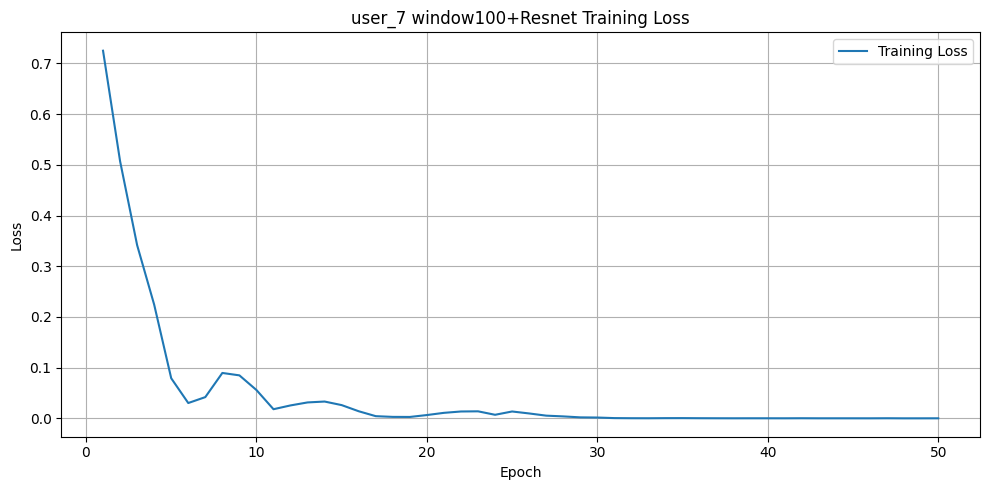

In [10]:
# 仅使用训练集进行训练
optim_ADAM, epoch, losslist, correctlist, train_correctlist = train_ADAM(
    model, 
    X_train_loader, 
    optimizer=optim_ADAM, 
    scheduler=warmup_scheduler,
    epoch=total_epochs,
    user_id=user_id, window_size=window_size
)

In [11]:
# 保存模型
state = {'model': model.state_dict()}
torch.save(state, f'D:/论文数据/mouse/model_pt/resnet/only-adam-user{user_id}_{window_size}-path.pt')

In [12]:
import torch

model = MouseNeuralNetwork2(length_single_mouse_traj=window_size)  # 替换为你的模型
params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Model has {params:,} trainable parameters")

Model has 7,219,266 trainable parameters


In [13]:
# 加载预训练模型
model_transfer = MouseNeuralNetwork(length_single_mouse_traj=window_size)  # 创建新模型
model_pretrain = MouseNeuralNetwork2(length_single_mouse_traj=window_size)  # 创建预训练模型结构


In [14]:
# 加载预训练权重 - 使用weights_only=True提高安全性
pretrain_path = f'D:/论文数据/mouse/model_pt/resnet/only-adam-user{user_id}_{window_size}-path.pt'
checkpoint = torch.load(pretrain_path,weights_only=True)  # 添加weights_only=True
print(f"Loading pretrained model from: {pretrain_path}")
model_pretrain.load_state_dict(checkpoint['model'])


Loading pretrained model from: D:/论文数据/mouse/model_pt/resnet/only-adam-user7_100-path.pt


<All keys matched successfully>

In [15]:
# 加载 ResNet1D 权重到 model_transfer.resnet
model_transfer.load_state_dict(checkpoint['model'], strict=False)
print("Pretrained ResNet1D weights loaded successfully.")

# 如果需要，可以选择冻结 ResNet1D 的参数
for param in model_transfer.resnet.parameters():
    param.requires_grad = False  # 冻结 ResNet1D 的参数

Pretrained ResNet1D weights loaded successfully.


In [16]:
# 加载保存的数据加载器
import pickle
base_path = f'D:/论文数据/mouse/data_pkl/processed_data_user{user_id}'

train_path = f'{base_path}/train_dataset_user{user_id}_{window_size}.pkl'
test_path = f'{base_path}/test_dataset_user{user_id}_{window_size}.pkl'
print(f"Loading data loaders for user {user_id}:")


# 加载时
with open(train_path, 'rb') as f:
    train_dataset = torch.load(f, pickle_module=pickle)

with open(test_path, 'rb') as f:
    test_dataset = torch.load(f, pickle_module=pickle)

# 重新创建 DataLoader
X_train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
X_test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

# 检查训练数据加载器内容
for batch_idx, (data, labels) in enumerate(X_train_loader):
    print(f"Batch {batch_idx}: data shape = {data.shape}, target shape = {labels.shape}")
    break  # 检查第一个批次即可

Loading data loaders for user 7:
Batch 0: data shape = torch.Size([128, 1, 100]), target shape = torch.Size([128])


In [17]:
# 将模型移到GPU
model_transfer = model_transfer.cuda()
print(f"Model moved to: {next(model_transfer.parameters()).device}")

Model moved to: cuda:0


In [18]:
max_lr_transfer = 1e-4
min_lr_transfer = 1e-7
warmup_epochs_transfer = 30
total_epochs_transfer = 200

In [19]:
# 初始化优化器

optim_ADAM_transfer = torch.optim.Adam(model_transfer.parameters(), lr=min_lr_transfer, weight_decay=1e-3)

# After warmup, use cosine annealing for (total_epochs - warmup_epochs) steps
cosine_scheduler_transfer = CosineAnnealingLR(optim_ADAM_transfer, T_max=(total_epochs_transfer - warmup_epochs_transfer), eta_min=min_lr_transfer)

# The multiplier is how much you multiply the initial LR to get the target LR at the end of warmup.
# If initial LR = 1e-7 and we want 1e-3 after warmup:
# multiplier = (desired_lr_after_warmup) / (initial_lr) = 1e-3 / 1e-7 = 10,000
multiplier_transfer = max_lr_transfer / min_lr_transfer

warmup_scheduler_transfer = GradualWarmupScheduler(optim_ADAM_transfer, multiplier=multiplier_transfer, total_epoch=warmup_epochs_transfer, after_scheduler=cosine_scheduler_transfer)

In [20]:
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
import torch
import torch.nn as nn
from IPython.display import clear_output
import matplotlib.pyplot as plt
import os

def train_ADAM_transfer(model, X_train_loader, optimizer=None, scheduler=None, epoch=300, user_id=None, window_size=None):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    loss_function = nn.CrossEntropyLoss()
    model = model.to(device)
    loss_function = loss_function.to(device)
    
    losslist = []
    correctlist = []
    train_correctlist = []
    
    writer = SummaryWriter('/root/tf-logs')
    pbar = tqdm(total=epoch, desc='Training Progress')
    
    for i in range(epoch):
        model.train()
        totalloss = 0
        correct = 0
        total = 0
        num_batches = 0
        
        for data in X_train_loader:
            X, label = data
            X = X.float().to(device)
            label = label.long().to(device)
            
            optimizer.zero_grad()
            pred = model(X).squeeze()
            loss = loss_function(pred, label)
           
            totalloss += loss.item()
            num_batches += 1
            _, pred_id = torch.max(pred, dim=1)
            correct += (pred_id == label).sum().cpu().detach().numpy()
            total += label.size(0)
            
            loss.backward()
            optimizer.step()
        
        if scheduler:
            scheduler.step()
        
        current_lr = scheduler.get_last_lr()[0]
        print(f"Epoch {i+1}: LR = {current_lr:.8f}")

        train_acc = correct / total
        avg_loss = totalloss / num_batches
        losslist.append(avg_loss)
        
        pbar.update(1)
        pbar.set_postfix({
            'loss': f'{avg_loss:.4f}',
            'acc': f'{train_acc:.4f}'
        })
        
        if (i + 1) % 100 == 0:
            print(f'Epoch {i+1}/{epoch} - Loss: {avg_loss:.4f}, Accuracy: {train_acc:.4f}')
            correctlist.append(train_acc)
            train_correctlist.append(train_acc)
            writer.add_scalar('Training loss', avg_loss, i)
            writer.add_scalar('Training accuracy', train_acc, i)
    
    pbar.close()
    writer.close()
    
    # 绘制损失曲线
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, epoch + 1), losslist, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')  
    plt.title(f'user_{user_id} window_{window_size}+Resnet+Gru Training Loss')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    
    # 创建保存路径（如果不存在）
    save_path = 'D:/论文数据/mouse/model_pt/ending_model/Loss_log'
    os.makedirs(save_path, exist_ok=True)
    
    # 保存图像，文件名与title一致
    plt.savefig(os.path.join(save_path, f'user_{user_id} window_{window_size} Resnet+Gru Training Loss.png'))
    plt.show()
    
    return optimizer, epoch, losslist, correctlist, train_correctlist

Training Progress:   0%|▏                                     | 1/200 [00:00<03:06,  1.07it/s, loss=0.7060, acc=0.0025]

Epoch 1: LR = 0.00000343


Training Progress:   1%|▍                                     | 2/200 [00:01<02:59,  1.10it/s, loss=0.6240, acc=0.8069]

Epoch 2: LR = 0.00000676


Training Progress:   2%|▌                                     | 3/200 [00:02<02:54,  1.13it/s, loss=0.4991, acc=0.8335]

Epoch 3: LR = 0.00001009


Training Progress:   2%|▊                                     | 4/200 [00:03<02:55,  1.11it/s, loss=0.4428, acc=0.8335]

Epoch 4: LR = 0.00001342


Training Progress:   2%|▉                                     | 5/200 [00:04<02:54,  1.12it/s, loss=0.4144, acc=0.8335]

Epoch 5: LR = 0.00001675


Training Progress:   3%|█▏                                    | 6/200 [00:05<02:53,  1.12it/s, loss=0.3737, acc=0.8335]

Epoch 6: LR = 0.00002008


Training Progress:   4%|█▎                                    | 7/200 [00:06<02:52,  1.12it/s, loss=0.3070, acc=0.8432]

Epoch 7: LR = 0.00002341


Training Progress:   4%|█▌                                    | 8/200 [00:07<02:50,  1.12it/s, loss=0.2218, acc=0.9109]

Epoch 8: LR = 0.00002674


Training Progress:   4%|█▋                                    | 9/200 [00:08<02:49,  1.13it/s, loss=0.1408, acc=0.9616]

Epoch 9: LR = 0.00003007


Training Progress:   5%|█▊                                   | 10/200 [00:08<02:48,  1.13it/s, loss=0.0861, acc=0.9839]

Epoch 10: LR = 0.00003340


Training Progress:   6%|██                                   | 11/200 [00:09<02:47,  1.13it/s, loss=0.0533, acc=0.9927]

Epoch 11: LR = 0.00003673


Training Progress:   6%|██▏                                  | 12/200 [00:10<02:44,  1.14it/s, loss=0.0358, acc=0.9943]

Epoch 12: LR = 0.00004006


Training Progress:   6%|██▍                                  | 13/200 [00:11<02:43,  1.14it/s, loss=0.0241, acc=0.9975]

Epoch 13: LR = 0.00004339


Training Progress:   7%|██▌                                  | 14/200 [00:12<02:41,  1.15it/s, loss=0.0161, acc=0.9989]

Epoch 14: LR = 0.00004672


Training Progress:   8%|██▊                                  | 15/200 [00:13<02:39,  1.16it/s, loss=0.0131, acc=0.9982]

Epoch 15: LR = 0.00005005


Training Progress:   8%|██▉                                  | 16/200 [00:14<02:39,  1.15it/s, loss=0.0092, acc=0.9995]

Epoch 16: LR = 0.00005338


Training Progress:   8%|███▏                                 | 17/200 [00:14<02:38,  1.16it/s, loss=0.0085, acc=0.9984]

Epoch 17: LR = 0.00005671


Training Progress:   9%|███▎                                 | 18/200 [00:15<02:37,  1.16it/s, loss=0.0061, acc=0.9994]

Epoch 18: LR = 0.00006004


Training Progress:  10%|███▌                                 | 19/200 [00:16<02:36,  1.16it/s, loss=0.0064, acc=0.9987]

Epoch 19: LR = 0.00006337


Training Progress:  10%|███▋                                 | 20/200 [00:17<02:37,  1.14it/s, loss=0.0035, acc=0.9999]

Epoch 20: LR = 0.00006670


Training Progress:  10%|███▉                                 | 21/200 [00:18<02:37,  1.14it/s, loss=0.0032, acc=0.9999]

Epoch 21: LR = 0.00007003


Training Progress:  11%|████                                 | 22/200 [00:19<02:36,  1.14it/s, loss=0.0032, acc=0.9995]

Epoch 22: LR = 0.00007336


Training Progress:  12%|████▎                                | 23/200 [00:20<02:36,  1.13it/s, loss=0.0027, acc=0.9996]

Epoch 23: LR = 0.00007669


Training Progress:  12%|████▍                                | 24/200 [00:21<02:34,  1.14it/s, loss=0.0017, acc=1.0000]

Epoch 24: LR = 0.00008002


Training Progress:  12%|████▋                                | 25/200 [00:21<02:31,  1.15it/s, loss=0.0023, acc=0.9995]

Epoch 25: LR = 0.00008335


Training Progress:  13%|████▊                                | 26/200 [00:22<02:31,  1.15it/s, loss=0.0014, acc=1.0000]

Epoch 26: LR = 0.00008668


Training Progress:  14%|████▉                                | 27/200 [00:23<02:31,  1.14it/s, loss=0.0017, acc=0.9997]

Epoch 27: LR = 0.00009001


Training Progress:  14%|█████▏                               | 28/200 [00:24<02:30,  1.14it/s, loss=0.0014, acc=0.9996]

Epoch 28: LR = 0.00009334


Training Progress:  14%|█████▎                               | 29/200 [00:25<02:29,  1.15it/s, loss=0.0009, acc=1.0000]

Epoch 29: LR = 0.00009667


Training Progress:  15%|█████▌                               | 30/200 [00:26<02:27,  1.15it/s, loss=0.0009, acc=1.0000]

Epoch 30: LR = 0.00010000


Training Progress:  16%|█████▋                               | 31/200 [00:27<02:27,  1.14it/s, loss=0.0006, acc=1.0000]

Epoch 31: LR = 0.00010000


Training Progress:  16%|█████▉                               | 32/200 [00:28<02:26,  1.15it/s, loss=0.0009, acc=1.0000]

Epoch 32: LR = 0.00010000


Training Progress:  16%|██████                               | 33/200 [00:28<02:24,  1.15it/s, loss=0.0010, acc=0.9999]

Epoch 33: LR = 0.00010000


Training Progress:  17%|██████▎                              | 34/200 [00:29<02:27,  1.13it/s, loss=0.0004, acc=1.0000]

Epoch 34: LR = 0.00010000


Training Progress:  18%|██████▍                              | 35/200 [00:30<02:28,  1.11it/s, loss=0.0006, acc=1.0000]

Epoch 35: LR = 0.00010000


Training Progress:  18%|██████▋                              | 36/200 [00:31<02:26,  1.12it/s, loss=0.0005, acc=1.0000]

Epoch 36: LR = 0.00010000


Training Progress:  18%|██████▊                              | 37/200 [00:32<02:24,  1.13it/s, loss=0.0005, acc=0.9999]

Epoch 37: LR = 0.00010000


Training Progress:  19%|███████                              | 38/200 [00:33<02:22,  1.13it/s, loss=0.0004, acc=1.0000]

Epoch 38: LR = 0.00010000


Training Progress:  20%|███████▏                             | 39/200 [00:34<02:24,  1.11it/s, loss=0.0004, acc=1.0000]

Epoch 39: LR = 0.00010000


Training Progress:  20%|███████▍                             | 40/200 [00:35<02:23,  1.11it/s, loss=0.0005, acc=1.0000]

Epoch 40: LR = 0.00010000


Training Progress:  20%|███████▌                             | 41/200 [00:36<02:22,  1.12it/s, loss=0.0005, acc=1.0000]

Epoch 41: LR = 0.00010000


Training Progress:  21%|███████▊                             | 42/200 [00:37<02:20,  1.13it/s, loss=0.0004, acc=1.0000]

Epoch 42: LR = 0.00010000


Training Progress:  22%|███████▉                             | 43/200 [00:37<02:18,  1.13it/s, loss=0.0008, acc=0.9997]

Epoch 43: LR = 0.00010000


Training Progress:  22%|████████▏                            | 44/200 [00:38<02:18,  1.13it/s, loss=0.0004, acc=0.9999]

Epoch 44: LR = 0.00010000


Training Progress:  22%|████████▎                            | 45/200 [00:39<02:18,  1.12it/s, loss=0.0003, acc=1.0000]

Epoch 45: LR = 0.00010000


Training Progress:  23%|████████▌                            | 46/200 [00:40<02:16,  1.13it/s, loss=0.0003, acc=1.0000]

Epoch 46: LR = 0.00010000


Training Progress:  24%|████████▋                            | 47/200 [00:41<02:17,  1.12it/s, loss=0.0003, acc=1.0000]

Epoch 47: LR = 0.00010000


Training Progress:  24%|████████▉                            | 48/200 [00:42<02:16,  1.11it/s, loss=0.0003, acc=1.0000]

Epoch 48: LR = 0.00010000


Training Progress:  24%|█████████                            | 49/200 [00:43<02:16,  1.11it/s, loss=0.0003, acc=1.0000]

Epoch 49: LR = 0.00010000


Training Progress:  25%|█████████▎                           | 50/200 [00:44<02:15,  1.11it/s, loss=0.0003, acc=1.0000]

Epoch 50: LR = 0.00010000


Training Progress:  26%|█████████▍                           | 51/200 [00:45<02:13,  1.11it/s, loss=0.0004, acc=0.9999]

Epoch 51: LR = 0.00010000


Training Progress:  26%|█████████▌                           | 52/200 [00:46<02:13,  1.11it/s, loss=0.0006, acc=0.9997]

Epoch 52: LR = 0.00010000


Training Progress:  26%|█████████▊                           | 53/200 [00:46<02:13,  1.10it/s, loss=0.0004, acc=0.9999]

Epoch 53: LR = 0.00010000


Training Progress:  27%|█████████▉                           | 54/200 [00:47<02:12,  1.10it/s, loss=0.0005, acc=1.0000]

Epoch 54: LR = 0.00010000


Training Progress:  28%|██████████▏                          | 55/200 [00:48<02:12,  1.09it/s, loss=0.0003, acc=1.0000]

Epoch 55: LR = 0.00010000


Training Progress:  28%|██████████▎                          | 56/200 [00:49<02:10,  1.11it/s, loss=0.0002, acc=1.0000]

Epoch 56: LR = 0.00010000


Training Progress:  28%|██████████▌                          | 57/200 [00:50<02:07,  1.12it/s, loss=0.0005, acc=0.9999]

Epoch 57: LR = 0.00010000


Training Progress:  29%|██████████▋                          | 58/200 [00:51<02:08,  1.11it/s, loss=0.0004, acc=1.0000]

Epoch 58: LR = 0.00010000


Training Progress:  30%|██████████▉                          | 59/200 [00:52<02:05,  1.13it/s, loss=0.0003, acc=0.9999]

Epoch 59: LR = 0.00010000


Training Progress:  30%|███████████                          | 60/200 [00:53<02:04,  1.13it/s, loss=0.0002, acc=1.0000]

Epoch 60: LR = 0.00010000


Training Progress:  30%|███████████▎                         | 61/200 [00:54<02:03,  1.13it/s, loss=0.0005, acc=0.9999]

Epoch 61: LR = 0.00010000


Training Progress:  31%|███████████▍                         | 62/200 [00:55<02:05,  1.10it/s, loss=0.0002, acc=1.0000]

Epoch 62: LR = 0.00010000


Training Progress:  32%|███████████▋                         | 63/200 [00:55<02:06,  1.08it/s, loss=0.0002, acc=1.0000]

Epoch 63: LR = 0.00010000


Training Progress:  32%|███████████▊                         | 64/200 [00:56<02:04,  1.09it/s, loss=0.0002, acc=1.0000]

Epoch 64: LR = 0.00010000


Training Progress:  32%|████████████                         | 65/200 [00:57<02:01,  1.11it/s, loss=0.0002, acc=1.0000]

Epoch 65: LR = 0.00010000


Training Progress:  33%|████████████▏                        | 66/200 [00:58<02:00,  1.12it/s, loss=0.0002, acc=1.0000]

Epoch 66: LR = 0.00010000


Training Progress:  34%|████████████▍                        | 67/200 [00:59<01:59,  1.11it/s, loss=0.0002, acc=1.0000]

Epoch 67: LR = 0.00010000


Training Progress:  34%|████████████▌                        | 68/200 [01:00<01:59,  1.10it/s, loss=0.0003, acc=1.0000]

Epoch 68: LR = 0.00010000


Training Progress:  34%|████████████▊                        | 69/200 [01:01<01:57,  1.11it/s, loss=0.0002, acc=1.0000]

Epoch 69: LR = 0.00010000


Training Progress:  35%|████████████▉                        | 70/200 [01:02<01:56,  1.11it/s, loss=0.0002, acc=1.0000]

Epoch 70: LR = 0.00010000


Training Progress:  36%|█████████████▏                       | 71/200 [01:03<01:55,  1.11it/s, loss=0.0003, acc=0.9999]

Epoch 71: LR = 0.00010000


Training Progress:  36%|█████████████▎                       | 72/200 [01:04<01:55,  1.11it/s, loss=0.0003, acc=1.0000]

Epoch 72: LR = 0.00010000


Training Progress:  36%|█████████████▌                       | 73/200 [01:04<01:54,  1.11it/s, loss=0.0006, acc=0.9997]

Epoch 73: LR = 0.00010000


Training Progress:  37%|█████████████▋                       | 74/200 [01:05<01:52,  1.12it/s, loss=0.0005, acc=0.9999]

Epoch 74: LR = 0.00010000


Training Progress:  38%|█████████████▉                       | 75/200 [01:06<01:52,  1.11it/s, loss=0.0002, acc=1.0000]

Epoch 75: LR = 0.00010000


Training Progress:  38%|██████████████                       | 76/200 [01:07<01:49,  1.13it/s, loss=0.0002, acc=1.0000]

Epoch 76: LR = 0.00010000


Training Progress:  38%|██████████████▏                      | 77/200 [01:08<01:48,  1.13it/s, loss=0.0003, acc=1.0000]

Epoch 77: LR = 0.00010000


Training Progress:  39%|██████████████▍                      | 78/200 [01:09<01:47,  1.13it/s, loss=0.0002, acc=1.0000]

Epoch 78: LR = 0.00010000


Training Progress:  40%|██████████████▌                      | 79/200 [01:10<01:46,  1.13it/s, loss=0.0002, acc=1.0000]

Epoch 79: LR = 0.00010000


Training Progress:  40%|██████████████▊                      | 80/200 [01:11<01:47,  1.12it/s, loss=0.0002, acc=1.0000]

Epoch 80: LR = 0.00010000


Training Progress:  40%|██████████████▉                      | 81/200 [01:12<01:45,  1.13it/s, loss=0.0002, acc=1.0000]

Epoch 81: LR = 0.00010000


Training Progress:  41%|███████████████▏                     | 82/200 [01:12<01:43,  1.14it/s, loss=0.0002, acc=1.0000]

Epoch 82: LR = 0.00010000


Training Progress:  42%|███████████████▎                     | 83/200 [01:13<01:43,  1.14it/s, loss=0.0002, acc=1.0000]

Epoch 83: LR = 0.00010000


Training Progress:  42%|███████████████▌                     | 84/200 [01:14<01:42,  1.13it/s, loss=0.0002, acc=1.0000]

Epoch 84: LR = 0.00010000


Training Progress:  42%|███████████████▋                     | 85/200 [01:15<01:41,  1.14it/s, loss=0.0003, acc=0.9999]

Epoch 85: LR = 0.00010000


Training Progress:  43%|███████████████▉                     | 86/200 [01:16<01:41,  1.13it/s, loss=0.0002, acc=1.0000]

Epoch 86: LR = 0.00010000


Training Progress:  44%|████████████████                     | 87/200 [01:17<01:39,  1.13it/s, loss=0.0003, acc=1.0000]

Epoch 87: LR = 0.00010000


Training Progress:  44%|████████████████▎                    | 88/200 [01:18<01:38,  1.14it/s, loss=0.0002, acc=1.0000]

Epoch 88: LR = 0.00010000


Training Progress:  44%|████████████████▍                    | 89/200 [01:19<01:37,  1.14it/s, loss=0.0002, acc=1.0000]

Epoch 89: LR = 0.00010000


Training Progress:  45%|████████████████▋                    | 90/200 [01:19<01:36,  1.14it/s, loss=0.0002, acc=1.0000]

Epoch 90: LR = 0.00010000


Training Progress:  46%|████████████████▊                    | 91/200 [01:20<01:35,  1.14it/s, loss=0.0002, acc=1.0000]

Epoch 91: LR = 0.00010000


Training Progress:  46%|█████████████████                    | 92/200 [01:21<01:35,  1.14it/s, loss=0.0003, acc=1.0000]

Epoch 92: LR = 0.00010000


Training Progress:  46%|█████████████████▏                   | 93/200 [01:22<01:33,  1.14it/s, loss=0.0008, acc=0.9996]

Epoch 93: LR = 0.00010000


Training Progress:  47%|█████████████████▍                   | 94/200 [01:23<01:33,  1.13it/s, loss=0.0003, acc=1.0000]

Epoch 94: LR = 0.00010000


Training Progress:  48%|█████████████████▌                   | 95/200 [01:24<01:33,  1.13it/s, loss=0.0002, acc=1.0000]

Epoch 95: LR = 0.00010000


Training Progress:  48%|█████████████████▊                   | 96/200 [01:25<01:32,  1.12it/s, loss=0.0003, acc=1.0000]

Epoch 96: LR = 0.00010000


Training Progress:  48%|█████████████████▉                   | 97/200 [01:26<01:33,  1.10it/s, loss=0.0002, acc=1.0000]

Epoch 97: LR = 0.00010000


Training Progress:  49%|██████████████████▏                  | 98/200 [01:27<01:32,  1.11it/s, loss=0.0002, acc=1.0000]

Epoch 98: LR = 0.00010000


Training Progress:  50%|██████████████████▎                  | 99/200 [01:27<01:30,  1.11it/s, loss=0.0001, acc=1.0000]

Epoch 99: LR = 0.00010000


Training Progress:  50%|██████████████████                  | 100/200 [01:28<01:29,  1.12it/s, loss=0.0002, acc=1.0000]

Epoch 100: LR = 0.00010000
Epoch 100/200 - Loss: 0.0002, Accuracy: 1.0000


Training Progress:  50%|██████████████████▏                 | 101/200 [01:29<01:27,  1.14it/s, loss=0.0003, acc=0.9999]

Epoch 101: LR = 0.00010000


Training Progress:  51%|██████████████████▎                 | 102/200 [01:30<01:25,  1.14it/s, loss=0.0002, acc=1.0000]

Epoch 102: LR = 0.00010000


Training Progress:  52%|██████████████████▌                 | 103/200 [01:31<01:25,  1.14it/s, loss=0.0002, acc=1.0000]

Epoch 103: LR = 0.00010000


Training Progress:  52%|██████████████████▋                 | 104/200 [01:32<01:24,  1.14it/s, loss=0.0002, acc=1.0000]

Epoch 104: LR = 0.00010000


Training Progress:  52%|██████████████████▉                 | 105/200 [01:33<01:23,  1.13it/s, loss=0.0003, acc=1.0000]

Epoch 105: LR = 0.00010000


Training Progress:  53%|███████████████████                 | 106/200 [01:34<01:22,  1.14it/s, loss=0.0003, acc=1.0000]

Epoch 106: LR = 0.00010000


Training Progress:  54%|███████████████████▎                | 107/200 [01:34<01:21,  1.14it/s, loss=0.0005, acc=0.9999]

Epoch 107: LR = 0.00010000


Training Progress:  54%|███████████████████▍                | 108/200 [01:35<01:20,  1.14it/s, loss=0.0003, acc=0.9999]

Epoch 108: LR = 0.00010000


Training Progress:  55%|███████████████████▌                | 109/200 [01:36<01:19,  1.14it/s, loss=0.0004, acc=0.9999]

Epoch 109: LR = 0.00010000


Training Progress:  55%|███████████████████▊                | 110/200 [01:37<01:19,  1.14it/s, loss=0.0002, acc=1.0000]

Epoch 110: LR = 0.00010000


Training Progress:  56%|███████████████████▉                | 111/200 [01:38<01:18,  1.14it/s, loss=0.0003, acc=1.0000]

Epoch 111: LR = 0.00010000


Training Progress:  56%|████████████████████▏               | 112/200 [01:39<01:16,  1.15it/s, loss=0.0007, acc=0.9999]

Epoch 112: LR = 0.00010000


Training Progress:  56%|████████████████████▎               | 113/200 [01:40<01:15,  1.15it/s, loss=0.0003, acc=1.0000]

Epoch 113: LR = 0.00010000


Training Progress:  57%|████████████████████▌               | 114/200 [01:41<01:14,  1.15it/s, loss=0.0002, acc=1.0000]

Epoch 114: LR = 0.00010000


Training Progress:  57%|████████████████████▋               | 115/200 [01:41<01:14,  1.14it/s, loss=0.0002, acc=1.0000]

Epoch 115: LR = 0.00010000


Training Progress:  58%|████████████████████▉               | 116/200 [01:42<01:14,  1.13it/s, loss=0.0002, acc=1.0000]

Epoch 116: LR = 0.00010000


Training Progress:  58%|█████████████████████               | 117/200 [01:43<01:13,  1.13it/s, loss=0.0002, acc=1.0000]

Epoch 117: LR = 0.00010000


Training Progress:  59%|█████████████████████▏              | 118/200 [01:44<01:12,  1.13it/s, loss=0.0004, acc=0.9999]

Epoch 118: LR = 0.00010000


Training Progress:  60%|█████████████████████▍              | 119/200 [01:45<01:11,  1.13it/s, loss=0.0002, acc=1.0000]

Epoch 119: LR = 0.00010000


Training Progress:  60%|█████████████████████▌              | 120/200 [01:46<01:10,  1.13it/s, loss=0.0001, acc=1.0000]

Epoch 120: LR = 0.00010000


Training Progress:  60%|█████████████████████▊              | 121/200 [01:47<01:09,  1.13it/s, loss=0.0002, acc=1.0000]

Epoch 121: LR = 0.00010000


Training Progress:  61%|█████████████████████▉              | 122/200 [01:48<01:08,  1.13it/s, loss=0.0002, acc=1.0000]

Epoch 122: LR = 0.00010000


Training Progress:  62%|██████████████████████▏             | 123/200 [01:49<01:07,  1.14it/s, loss=0.0003, acc=1.0000]

Epoch 123: LR = 0.00010000


Training Progress:  62%|██████████████████████▎             | 124/200 [01:49<01:07,  1.13it/s, loss=0.0002, acc=1.0000]

Epoch 124: LR = 0.00010000


Training Progress:  62%|██████████████████████▌             | 125/200 [01:50<01:05,  1.14it/s, loss=0.0003, acc=1.0000]

Epoch 125: LR = 0.00010000


Training Progress:  63%|██████████████████████▋             | 126/200 [01:51<01:05,  1.13it/s, loss=0.0003, acc=0.9999]

Epoch 126: LR = 0.00010000


Training Progress:  64%|██████████████████████▊             | 127/200 [01:52<01:04,  1.13it/s, loss=0.0004, acc=0.9999]

Epoch 127: LR = 0.00010000


Training Progress:  64%|███████████████████████             | 128/200 [01:53<01:03,  1.13it/s, loss=0.0002, acc=1.0000]

Epoch 128: LR = 0.00010000


Training Progress:  64%|███████████████████████▏            | 129/200 [01:54<01:02,  1.14it/s, loss=0.0002, acc=1.0000]

Epoch 129: LR = 0.00010000


Training Progress:  65%|███████████████████████▍            | 130/200 [01:55<01:01,  1.14it/s, loss=0.0002, acc=1.0000]

Epoch 130: LR = 0.00010000


Training Progress:  66%|███████████████████████▌            | 131/200 [01:56<01:01,  1.13it/s, loss=0.0001, acc=1.0000]

Epoch 131: LR = 0.00010000


Training Progress:  66%|███████████████████████▊            | 132/200 [01:56<00:59,  1.14it/s, loss=0.0002, acc=1.0000]

Epoch 132: LR = 0.00010000


Training Progress:  66%|███████████████████████▉            | 133/200 [01:57<00:58,  1.14it/s, loss=0.0002, acc=1.0000]

Epoch 133: LR = 0.00010000


Training Progress:  67%|████████████████████████            | 134/200 [01:58<00:57,  1.14it/s, loss=0.0003, acc=1.0000]

Epoch 134: LR = 0.00010000


Training Progress:  68%|████████████████████████▎           | 135/200 [01:59<00:56,  1.14it/s, loss=0.0002, acc=1.0000]

Epoch 135: LR = 0.00010000


Training Progress:  68%|████████████████████████▍           | 136/200 [02:00<00:56,  1.14it/s, loss=0.0002, acc=1.0000]

Epoch 136: LR = 0.00010000


Training Progress:  68%|████████████████████████▋           | 137/200 [02:01<00:54,  1.15it/s, loss=0.0002, acc=1.0000]

Epoch 137: LR = 0.00010000


Training Progress:  69%|████████████████████████▊           | 138/200 [02:02<00:53,  1.16it/s, loss=0.0002, acc=1.0000]

Epoch 138: LR = 0.00010000


Training Progress:  70%|█████████████████████████           | 139/200 [02:03<00:52,  1.15it/s, loss=0.0003, acc=1.0000]

Epoch 139: LR = 0.00010000


Training Progress:  70%|█████████████████████████▏          | 140/200 [02:03<00:52,  1.14it/s, loss=0.0002, acc=1.0000]

Epoch 140: LR = 0.00010000


Training Progress:  70%|█████████████████████████▍          | 141/200 [02:04<00:53,  1.11it/s, loss=0.0003, acc=0.9999]

Epoch 141: LR = 0.00010000


Training Progress:  71%|█████████████████████████▌          | 142/200 [02:05<00:52,  1.11it/s, loss=0.0003, acc=0.9999]

Epoch 142: LR = 0.00010000


Training Progress:  72%|█████████████████████████▋          | 143/200 [02:06<00:50,  1.12it/s, loss=0.0001, acc=1.0000]

Epoch 143: LR = 0.00010000


Training Progress:  72%|█████████████████████████▉          | 144/200 [02:07<00:50,  1.12it/s, loss=0.0003, acc=1.0000]

Epoch 144: LR = 0.00010000


Training Progress:  72%|██████████████████████████          | 145/200 [02:08<00:48,  1.12it/s, loss=0.0002, acc=1.0000]

Epoch 145: LR = 0.00010000


Training Progress:  73%|██████████████████████████▎         | 146/200 [02:09<00:47,  1.13it/s, loss=0.0004, acc=0.9999]

Epoch 146: LR = 0.00010000


Training Progress:  74%|██████████████████████████▍         | 147/200 [02:10<00:47,  1.12it/s, loss=0.0006, acc=0.9997]

Epoch 147: LR = 0.00010000


Training Progress:  74%|██████████████████████████▋         | 148/200 [02:11<00:46,  1.12it/s, loss=0.0002, acc=1.0000]

Epoch 148: LR = 0.00010000


Training Progress:  74%|██████████████████████████▊         | 149/200 [02:12<00:45,  1.11it/s, loss=0.0003, acc=1.0000]

Epoch 149: LR = 0.00010000


Training Progress:  75%|███████████████████████████         | 150/200 [02:12<00:44,  1.11it/s, loss=0.0002, acc=1.0000]

Epoch 150: LR = 0.00010000


Training Progress:  76%|███████████████████████████▏        | 151/200 [02:13<00:43,  1.12it/s, loss=0.0002, acc=1.0000]

Epoch 151: LR = 0.00010000


Training Progress:  76%|███████████████████████████▎        | 152/200 [02:14<00:42,  1.13it/s, loss=0.0010, acc=0.9996]

Epoch 152: LR = 0.00010000


Training Progress:  76%|███████████████████████████▌        | 153/200 [02:15<00:41,  1.13it/s, loss=0.0002, acc=1.0000]

Epoch 153: LR = 0.00010000


Training Progress:  77%|███████████████████████████▋        | 154/200 [02:16<00:40,  1.13it/s, loss=0.0002, acc=1.0000]

Epoch 154: LR = 0.00010000


Training Progress:  78%|███████████████████████████▉        | 155/200 [02:17<00:39,  1.13it/s, loss=0.0002, acc=1.0000]

Epoch 155: LR = 0.00010000


Training Progress:  78%|████████████████████████████        | 156/200 [02:18<00:38,  1.13it/s, loss=0.0002, acc=1.0000]

Epoch 156: LR = 0.00010000


Training Progress:  78%|████████████████████████████▎       | 157/200 [02:19<00:38,  1.12it/s, loss=0.0002, acc=1.0000]

Epoch 157: LR = 0.00010000


Training Progress:  79%|████████████████████████████▍       | 158/200 [02:20<00:37,  1.13it/s, loss=0.0002, acc=1.0000]

Epoch 158: LR = 0.00010000


Training Progress:  80%|████████████████████████████▌       | 159/200 [02:20<00:36,  1.12it/s, loss=0.0002, acc=1.0000]

Epoch 159: LR = 0.00010000


Training Progress:  80%|████████████████████████████▊       | 160/200 [02:21<00:35,  1.11it/s, loss=0.0002, acc=1.0000]

Epoch 160: LR = 0.00010000


Training Progress:  80%|████████████████████████████▉       | 161/200 [02:22<00:34,  1.12it/s, loss=0.0003, acc=1.0000]

Epoch 161: LR = 0.00010000


Training Progress:  81%|█████████████████████████████▏      | 162/200 [02:23<00:33,  1.12it/s, loss=0.0002, acc=1.0000]

Epoch 162: LR = 0.00010000


Training Progress:  82%|█████████████████████████████▎      | 163/200 [02:24<00:32,  1.13it/s, loss=0.0002, acc=1.0000]

Epoch 163: LR = 0.00010000


Training Progress:  82%|█████████████████████████████▌      | 164/200 [02:25<00:32,  1.12it/s, loss=0.0001, acc=1.0000]

Epoch 164: LR = 0.00010000


Training Progress:  82%|█████████████████████████████▋      | 165/200 [02:26<00:31,  1.10it/s, loss=0.0002, acc=1.0000]

Epoch 165: LR = 0.00010000


Training Progress:  83%|█████████████████████████████▉      | 166/200 [02:27<00:30,  1.11it/s, loss=0.0005, acc=0.9999]

Epoch 166: LR = 0.00010000


Training Progress:  84%|██████████████████████████████      | 167/200 [02:28<00:29,  1.12it/s, loss=0.0001, acc=1.0000]

Epoch 167: LR = 0.00010000


Training Progress:  84%|██████████████████████████████▏     | 168/200 [02:28<00:28,  1.13it/s, loss=0.0002, acc=1.0000]

Epoch 168: LR = 0.00010000


Training Progress:  84%|██████████████████████████████▍     | 169/200 [02:29<00:27,  1.12it/s, loss=0.0001, acc=1.0000]

Epoch 169: LR = 0.00010000


Training Progress:  85%|██████████████████████████████▌     | 170/200 [02:30<00:26,  1.12it/s, loss=0.0002, acc=1.0000]

Epoch 170: LR = 0.00010000


Training Progress:  86%|██████████████████████████████▊     | 171/200 [02:31<00:25,  1.12it/s, loss=0.0002, acc=1.0000]

Epoch 171: LR = 0.00010000


Training Progress:  86%|██████████████████████████████▉     | 172/200 [02:32<00:25,  1.12it/s, loss=0.0001, acc=1.0000]

Epoch 172: LR = 0.00010000


Training Progress:  86%|███████████████████████████████▏    | 173/200 [02:33<00:24,  1.11it/s, loss=0.0002, acc=1.0000]

Epoch 173: LR = 0.00010000


Training Progress:  87%|███████████████████████████████▎    | 174/200 [02:34<00:23,  1.11it/s, loss=0.0001, acc=1.0000]

Epoch 174: LR = 0.00010000


Training Progress:  88%|███████████████████████████████▌    | 175/200 [02:35<00:22,  1.12it/s, loss=0.0002, acc=1.0000]

Epoch 175: LR = 0.00010000


Training Progress:  88%|███████████████████████████████▋    | 176/200 [02:36<00:21,  1.11it/s, loss=0.0001, acc=1.0000]

Epoch 176: LR = 0.00010000


Training Progress:  88%|███████████████████████████████▊    | 177/200 [02:37<00:20,  1.11it/s, loss=0.0001, acc=1.0000]

Epoch 177: LR = 0.00010000


Training Progress:  89%|████████████████████████████████    | 178/200 [02:37<00:19,  1.12it/s, loss=0.0001, acc=1.0000]

Epoch 178: LR = 0.00010000


Training Progress:  90%|████████████████████████████████▏   | 179/200 [02:38<00:18,  1.12it/s, loss=0.0003, acc=1.0000]

Epoch 179: LR = 0.00010000


Training Progress:  90%|████████████████████████████████▍   | 180/200 [02:39<00:18,  1.11it/s, loss=0.0002, acc=1.0000]

Epoch 180: LR = 0.00010000


Training Progress:  90%|████████████████████████████████▌   | 181/200 [02:40<00:17,  1.11it/s, loss=0.0003, acc=1.0000]

Epoch 181: LR = 0.00010000


Training Progress:  91%|████████████████████████████████▊   | 182/200 [02:41<00:16,  1.12it/s, loss=0.0003, acc=0.9999]

Epoch 182: LR = 0.00010000


Training Progress:  92%|████████████████████████████████▉   | 183/200 [02:42<00:15,  1.11it/s, loss=0.0003, acc=0.9999]

Epoch 183: LR = 0.00010000


Training Progress:  92%|█████████████████████████████████   | 184/200 [02:43<00:14,  1.11it/s, loss=0.0002, acc=1.0000]

Epoch 184: LR = 0.00010000


Training Progress:  92%|█████████████████████████████████▎  | 185/200 [02:44<00:13,  1.12it/s, loss=0.0003, acc=1.0000]

Epoch 185: LR = 0.00010000


Training Progress:  93%|█████████████████████████████████▍  | 186/200 [02:45<00:12,  1.12it/s, loss=0.0004, acc=0.9999]

Epoch 186: LR = 0.00010000


Training Progress:  94%|█████████████████████████████████▋  | 187/200 [02:46<00:11,  1.11it/s, loss=0.0002, acc=1.0000]

Epoch 187: LR = 0.00010000


Training Progress:  94%|█████████████████████████████████▊  | 188/200 [02:46<00:10,  1.11it/s, loss=0.0002, acc=1.0000]

Epoch 188: LR = 0.00010000


Training Progress:  94%|██████████████████████████████████  | 189/200 [02:47<00:09,  1.12it/s, loss=0.0006, acc=0.9997]

Epoch 189: LR = 0.00010000


Training Progress:  95%|██████████████████████████████████▏ | 190/200 [02:48<00:09,  1.11it/s, loss=0.0002, acc=1.0000]

Epoch 190: LR = 0.00010000


Training Progress:  96%|██████████████████████████████████▍ | 191/200 [02:49<00:08,  1.11it/s, loss=0.0002, acc=1.0000]

Epoch 191: LR = 0.00010000


Training Progress:  96%|██████████████████████████████████▌ | 192/200 [02:50<00:07,  1.12it/s, loss=0.0005, acc=0.9997]

Epoch 192: LR = 0.00010000


Training Progress:  96%|██████████████████████████████████▋ | 193/200 [02:51<00:06,  1.12it/s, loss=0.0002, acc=1.0000]

Epoch 193: LR = 0.00010000


Training Progress:  97%|██████████████████████████████████▉ | 194/200 [02:52<00:05,  1.12it/s, loss=0.0004, acc=1.0000]

Epoch 194: LR = 0.00010000


Training Progress:  98%|███████████████████████████████████ | 195/200 [02:53<00:04,  1.12it/s, loss=0.0003, acc=1.0000]

Epoch 195: LR = 0.00010000


Training Progress:  98%|███████████████████████████████████▎| 196/200 [02:54<00:03,  1.12it/s, loss=0.0002, acc=1.0000]

Epoch 196: LR = 0.00010000


Training Progress:  98%|███████████████████████████████████▍| 197/200 [02:54<00:02,  1.12it/s, loss=0.0002, acc=1.0000]

Epoch 197: LR = 0.00010000


Training Progress:  99%|███████████████████████████████████▋| 198/200 [02:55<00:01,  1.11it/s, loss=0.0002, acc=1.0000]

Epoch 198: LR = 0.00010000


Training Progress: 100%|███████████████████████████████████▊| 199/200 [02:56<00:00,  1.10it/s, loss=0.0003, acc=1.0000]

Epoch 199: LR = 0.00010000


Training Progress: 100%|████████████████████████████████████| 200/200 [02:57<00:00,  1.13it/s, loss=0.0001, acc=1.0000]

Epoch 200: LR = 0.00010000
Epoch 200/200 - Loss: 0.0001, Accuracy: 1.0000


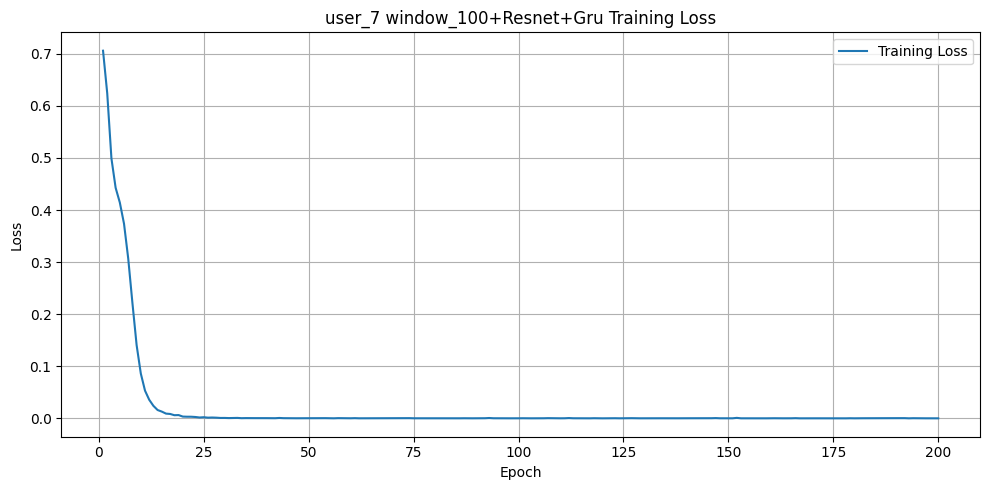

In [21]:
# 训练迁移模型
optim_ADAM, epoch, losslist, correctlist, train_correctlist = train_ADAM_transfer(
    model_transfer, 
    X_train_loader, 
    optimizer=optim_ADAM_transfer, 
    scheduler=warmup_scheduler_transfer,
    epoch=total_epochs_transfer,
    user_id=user_id, window_size=window_size
)

In [22]:
# 保存迁移后的模型
transfer_save_path = f'D:/论文数据/mouse/model_pt/ending_model/gru-transfer-user{user_id}_{window_size}-path.pt'  # 修改为实际路径
state = {
    'model': model_transfer.state_dict(),
    'epoch': epoch
}
torch.save(state, transfer_save_path)
print(f"Transfer model saved to: {transfer_save_path}")

Transfer model saved to: D:/论文数据/mouse/model_pt/ending_model/gru-transfer-user7_100-path.pt


In [23]:
import torch

model = MouseNeuralNetwork(X.shape[2])  # 替换为你的模型
params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Model has {params:,} trainable parameters")

Model has 7,265,517 trainable parameters


In [24]:
import os
import sys
import math
import csv

import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics

import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils import data
from torch.utils.data import (
    DataLoader,
    RandomSampler,
    SequentialSampler,
    TensorDataset,
    WeightedRandomSampler,
    random_split
)
import torchvision
from torchvision.datasets import mnist

from torch.optim.lr_scheduler import CosineAnnealingLR
from warmup_scheduler import GradualWarmupScheduler

# 设置项目根目录
project_root = "C:/Users/Admin/Mouse"  # 替换为您的项目根目录路径
datautils_path = os.path.join(project_root, 'datautils')
model_path = os.path.join(project_root, 'model')

# 添加自定义模块路径
sys.path.extend([datautils_path, model_path])

# 导入自定义模块
from data_utils import load_mouse_data, process_mouse_data
from resnet_mouse import  BasicBlock1D, ResNet1D
from mouse_traj_classification import MouseNeuralNetwork, MouseNeuralNetwork2
from new_optim import SWATS
import time

# 获取当前工作目录（可选）
pwd = os.getcwd()
# print(pwd)


In [25]:
def save_results_to_csv(user_id, window_size, metrics_dict, csv_path):
    """
    保存结果到CSV文件
    Args:
        user_id: 用户ID
        window_size: 窗口大小
        metrics_dict: 包含各项指标的字典
        csv_path: CSV文件路径
    """
    # 定义列名
    columns = ['user_id', 'window_size', 'recall', 'accuracy', 'precision', 'F1', 'AUC', 'EER']
    
    # 检查文件是否存在
    if os.path.exists(csv_path):
        df = pd.read_csv(csv_path)
    else:
        df = pd.DataFrame(columns=columns)
    
    # 创建新行数据
    new_row = pd.DataFrame([{
        'user_id': f'user{user_id}',
        'window_size': window_size,
        'recall': metrics_dict['recall'],
        'accuracy': metrics_dict['accuracy'],
        'precision': metrics_dict['precision'],
        'F1': metrics_dict['f1'],
        'AUC': metrics_dict['auc'],
        'EER': metrics_dict['eer']
    }])
    
    # 使用concat替代append
    df = pd.concat([df, new_row], ignore_index=True)
    
    # 保存到CSV
    df.to_csv(csv_path, index=False)
    print(f"Results saved to {csv_path}")

In [26]:
# 评估函数
def val(model, data_loader):
    correct = 0 
    fenmu = 0
    New_label = []
    
    total_inference_time = 0
    num_inferences = 0

    for data in data_loader:
        X, label = data
        model.zero_grad()
        
        start_time = time.time()
        pred = model(X).squeeze()
        end_time = time.time()
        
        total_inference_time += (end_time - start_time)
        num_inferences += X.size(0)
        
        _, pred_id = torch.max(pred, dim=1)
        correct += (pred_id == label).sum().cpu().detach().numpy()
        New_label.append(label)
        fenmu += label.size(0)
        
    correct = correct / fenmu
    avg_inference_time = total_inference_time / num_inferences
    print(f"Average inference time: {avg_inference_time:.6f} seconds")
    
    return pred_id, pred, label

def recall(predictions, labels):
    TP, FP, TN, FN = 0, 0, 0, 0
    for i in range(len(predictions)):
        if predictions[i] == 1 and labels[i] == 1:
            TP += 1
        elif predictions[i] == 1 and labels[i] == 0:
            FP += 1
        elif predictions[i] == 0 and labels[i] == 0:
            TN += 1
        elif predictions[i] == 0 and labels[i] == 1:
            FN += 1
    if (TP + FN) == 0:
        print(predictions)
        print(labels)
    recall = TP / (TP + FN)
    return recall

def et_TPFN(predictions, labels):
    TP, FP, TN, FN = 0, 0, 0, 0
    for i in range(len(predictions)):
        if predictions[i] == 1 and labels[i] == 1:
            TP += 1
        elif predictions[i] == 1 and labels[i] == 0:
            FP += 1
        elif predictions[i] == 0 and labels[i] == 0:
            TN += 1
        elif predictions[i] == 0 and labels[i] == 1:
            FN += 1
    return TP, FP, TN, FN

def pre(predictions, labels):
    TP, FP, TN, FN = 0, 0, 0, 0
    for i in range(len(predictions)):
        if predictions[i] == 1 and labels[i] == 1:
            TP += 1
        elif predictions[i] == 1 and labels[i] == 0:
            FP += 1
        elif predictions[i] == 0 and labels[i] == 0:
            TN += 1
        elif predictions[i] == 0 and labels[i] == 1:
            FN += 1
    return TP/(FP+TP)
# 在评估函数部分添加新的指标计算函数
def calculate_f1(precision, recall):
    """计算F1分数"""
    if precision + recall == 0:
        return 0
    return 2 * (precision * recall) / (precision + recall)

def calculate_eer(fpr, tpr):
    """计算EER (Equal Error Rate)"""
    fnr = 1 - tpr
    # EER是当FAR(FPR)等于FRR(FNR)时的值
    eer = fpr[np.nanargmin(np.absolute(fnr - fpr))]
    return eer

In [27]:
import dill
import torch
import json
import numpy as np


# 1. 加载原始测试数据
test_dataset_path = f'D:/论文数据/mouse/data_pkl/processed_data_user{user_id}/test_dataset_user{user_id}_{window_size}.pkl'
print(f"\nLoading test data from: {test_dataset_path}")
with open(test_dataset_path, 'rb') as f:
    test_dataset = torch.load(f, pickle_module=pickle)
X_test_loader = DataLoader(test_dataset, batch_size=100, shuffle=True)
# 重新创建 DataLoader
# X_train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
# X_test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)



Loading test data from: D:/论文数据/mouse/data_pkl/processed_data_user7/test_dataset_user7_100.pkl


In [28]:
import torch
import json
import numpy as np
import pickle
from torch.utils.data import TensorDataset, DataLoader, SubsetRandomSampler

def create_proportional_dataloader(X, y, batch_size=256):
    # 计算正负样本的比例
    pos_indices = (y == 0).nonzero(as_tuple=True)[0]
    neg_indices = (y == 1).nonzero(as_tuple=True)[0]
    
    # 创建一个平衡的索引列表
    total_samples = len(y)
    all_indices = []
    
    # 计算每个batch应该包含的正负样本数量
    pos_ratio = len(pos_indices) / total_samples
    neg_ratio = len(neg_indices) / total_samples
    
    # 打乱正负样本的索引
    pos_indices = pos_indices[torch.randperm(len(pos_indices))]
    neg_indices = neg_indices[torch.randperm(len(neg_indices))]
    
    pos_idx = 0
    neg_idx = 0
    
    # 按比例交替添加正负样本的索引
    while pos_idx < len(pos_indices) or neg_idx < len(neg_indices):
        # 添加正样本
        remaining_pos = min(int(batch_size * pos_ratio), len(pos_indices) - pos_idx)
        if remaining_pos > 0:
            all_indices.extend(pos_indices[pos_idx:pos_idx + remaining_pos].tolist())
            pos_idx += remaining_pos
            
        # 添加负样本
        remaining_neg = min(int(batch_size * neg_ratio), len(neg_indices) - neg_idx)
        if remaining_neg > 0:
            all_indices.extend(neg_indices[neg_idx:neg_idx + remaining_neg].tolist())
            neg_idx += remaining_neg

        # 计算完整batch数量
    num_complete_batches = len(all_indices) // batch_size
    
    # 如果有不完整的最后一个batch，删除它
    if len(all_indices) % batch_size != 0:
        all_indices = all_indices[:num_complete_batches * batch_size]
    
    # 创建数据集和dataloader
    dataset = TensorDataset(X, y)
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        sampler=SubsetRandomSampler(all_indices)
    )
    
    return dataloader

# 1. 加载处理后的测试数据集
test_dataset_path = f'D:/论文数据/mouse/data_pkl/processed_data_user{user_id}/test_dataset_user{user_id}_{window_size}.pkl'
print(f"\nLoading test data from: {test_dataset_path}")
with open(test_dataset_path, 'rb') as f:
    test_dataset = torch.load(f, pickle_module=pickle)

# 提取 X_test 和 y_test
if isinstance(test_dataset, TensorDataset):
    X_test, y_test = test_dataset.tensors
else:
    raise ValueError("Unexpected format of test_dataset. Expected TensorDataset.")

# 创建保持原有比例的数据加载器
X_test_loader = create_proportional_dataloader(X_test, y_test, batch_size=256)

print(f"\nOriginal Test Dataset Statistics:")
print(f"Total number of samples: {len(X_test)}")
print(f"Positive (0): {(y_test == 0).sum().item()}")
print(f"Negative (1): {(y_test == 1).sum().item()}")
print(f"Sample shape: {X_test.shape[1:]}")
print(f"Data type of X_test: {X_test.dtype}")
print(f"Data type of y_test: {y_test.dtype}")

# 2. 加载和处理预测数据
predict_path = f'D:/论文数据/mouse/data/processed_data_user{user_id}/predict_samples_user{user_id}_{window_size}.json'
print(f"\nLoading predict data from: {predict_path}")

with open(predict_path, 'r') as f:
    predict_data = json.load(f)

# 将预测数据转换为 tensor
trajectories = []
feature_names = predict_data['metadata']['feature_names']
for sample in predict_data['samples']:
    trajectory = np.array([[step[feature] for feature in feature_names] for step in sample])
    trajectories.append(trajectory)

X_predict = np.array(trajectories)
X_predict = torch.FloatTensor(X_predict).transpose(1, 2)  # [N, features, time]

# 检查测试集数据的维度，确保与预测数据一致
if X_test.dim() != X_predict.dim() or X_test.shape[1:] != X_predict.shape[1:]:
    raise ValueError(f"Dimension mismatch between test_data and X_predict.\n"
                     f"test_data shape: {X_test.shape}, X_predict shape: {X_predict.shape}")

print(f"Predict samples shape after processing: {X_predict.shape}")
print(f"Data type of X_predict: {X_predict.dtype}")

# 3. 插入预测样本，确保插入样本数与测试集中的负样本数相同
num_neg_test = (y_test == 1).sum().item()
print(f"\nNumber of negative samples in test set: {num_neg_test}")

if len(X_predict) < num_neg_test:
    print(f"Warning: Only {len(X_predict)} predict samples available, less than required {num_neg_test}")
    desired_predict = len(X_predict)  # 若不够则使用全部
else:
    desired_predict = num_neg_test

print(f"Number of predict samples to insert: {desired_predict}")

# 随机选择预测样本
indices = torch.randperm(len(X_predict))[:desired_predict]
X_insert = X_predict[indices]

# 创建对应的预测样本标签（使用1表示负样本，确保类型与 y_test 相同）
label_insert = torch.ones(len(X_insert), dtype=y_test.dtype)

# 合并预测样本与原始测试样本
X_test_final = torch.cat([X_test, X_insert], dim=0)
y_test_final = torch.cat([y_test, label_insert], dim=0)

print("\nFinal Test Dataset Statistics:")
print(f"Total number of samples: {len(X_test_final)}")
print(f"Positive (0): {(y_test_final == 0).sum().item()}")
print(f"Negative (1): {(y_test_final == 1).sum().item()}")
print(f"Data shape: {X_test_final.shape[1:]}")
print(f"Data type of X_test_final: {X_test_final.dtype}")
print(f"Data type of y_test_final: {y_test_final.dtype}")

# 4. 随机打乱最终的测试集
final_test_indices = torch.randperm(len(X_test_final))
X_test_final = X_test_final[final_test_indices]
y_test_final = y_test_final[final_test_indices]

# 5. 创建最终的测试数据集和 DataLoader
final_test_dataset = TensorDataset(X_test_final, y_test_final)
test_loader_final = create_proportional_dataloader(X_test_final, y_test_final, batch_size=256)

print(f"\nFinal Test Loader:")
print(f"Number of samples: {len(test_loader_final.dataset)}")
print(f"Batch size: {test_loader_final.batch_size}")

# 6. 创建新的测试 DataLoader
print("\nCreating new test DataLoader from the selected final samples...")
new_test_dataloader = create_proportional_dataloader(X_test_final, y_test_final, batch_size=256)

# 打印插入后的 shape 信息（单个样本的形状）
shape_new_single_mouse_traj = X_test_final.shape[1:]
print(f"Shape after insertion: {shape_new_single_mouse_traj}")

# 检查 new_test_dataloader 的详细信息
print("\nNew Test DataLoader Details:")
total_samples = 0
total_batches = 0
batch_sizes = []

for batch_idx, (X, labels) in enumerate(new_test_dataloader):
    total_samples += len(X)
    total_batches += 1
    batch_sizes.append(len(X))
    if batch_idx == 0:
        print(f"Single batch shape: {X.shape}")
        # 假设 X 的 shape 为 [batch, feature, seq_length]
        print(f"Features dimension: {X.shape[1]}")
        print(f"Sequence length: {X.shape[2]}")

print(f"\nTotal number of samples: {total_samples}")
print(f"Number of batches: {total_batches}")
print(f"Batch sizes: {batch_sizes}")

# 检查标签分布
all_labels = []
for _, labels in new_test_dataloader:
    all_labels.extend(labels.cpu().numpy())

unique_labels, counts = np.unique(all_labels, return_counts=True)
print("\nLabel distribution:")
for label, count in zip(unique_labels, counts):
    print(f"Label {label}: {count} samples")

# 检查 X_test_loader 的详细信息
print("\nChecking X_test_loader Details:")
total_samples_test_loader = 0
total_batches_test_loader = 0
batch_sizes_test_loader = []

for batch_idx, (X, labels) in enumerate(X_test_loader):
    total_samples_test_loader += len(X)
    total_batches_test_loader += 1
    batch_sizes_test_loader.append(len(X))
    if batch_idx == 0:
        print(f"Single batch shape: {X.shape}")
        if X.dim() >= 3:
            print(f"Features dimension: {X.shape[1]}")
            print(f"Sequence length: {X.shape[2]}")
        elif X.dim() == 2:
            print(f"Features dimension: {X.shape[1]}")
            print(f"No sequence length (2D data).")
        else:
            print(f"Unexpected data shape for X: {X.shape}")

print(f"\nX_test_loader Total Samples: {total_samples_test_loader}")
print(f"X_test_loader Number of Batches: {total_batches_test_loader}")
print(f"X_test_loader Batch sizes: {batch_sizes_test_loader}")

# 检查标签分布
all_labels_test_loader = []
for _, labels in X_test_loader:
    all_labels_test_loader.extend(labels.cpu().numpy())

unique_labels_test_loader, counts_test_loader = np.unique(all_labels_test_loader, return_counts=True)
print("\nX_test_loader Label distribution:")
for label, count in zip(unique_labels_test_loader, counts_test_loader):
    print(f"Label {label}: {count} samples")


Loading test data from: D:/论文数据/mouse/data_pkl/processed_data_user7/test_dataset_user7_100.pkl

Original Test Dataset Statistics:
Total number of samples: 3401
Positive (0): 2834
Negative (1): 567
Sample shape: torch.Size([1, 100])
Data type of X_test: torch.float32
Data type of y_test: torch.float32

Loading predict data from: D:/论文数据/mouse/data/processed_data_user7/predict_samples_user7_100.json
Predict samples shape after processing: torch.Size([1889, 1, 100])
Data type of X_predict: torch.float32

Number of negative samples in test set: 567
Number of predict samples to insert: 567

Final Test Dataset Statistics:
Total number of samples: 3968
Positive (0): 2834
Negative (1): 1134
Data shape: torch.Size([1, 100])
Data type of X_test_final: torch.float32
Data type of y_test_final: torch.float32

Final Test Loader:
Number of samples: 3968
Batch size: 256

Creating new test DataLoader from the selected final samples...
Shape after insertion: torch.Size([1, 100])

New Test DataLoader De

In [29]:
# 3. 创建和加载模型
New_model_new_test = MouseNeuralNetwork(length_single_mouse_traj=window_size)
model_path = f'D:/论文数据/mouse/model_pt/ending_model/gru-transfer-user{user_id}_{window_size}-path.pt'
print(f"\nLoading model from: {model_path}")
checkpoint = torch.load(model_path) 
New_model_new_test.load_state_dict(checkpoint['model'])


Loading model from: D:/论文数据/mouse/model_pt/ending_model/gru-transfer-user7_100-path.pt


C:\Users\Admin\AppData\Local\Temp\ipykernel_19884\1691636379.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


<All keys matched successfully>

In [30]:
from sklearn import metrics
import numpy as np
import os
import torch


# 4. 评估原始测试集
print("\nEvaluating original test set...")
d_c = []           # Recall
d_acc = []         # Accuracy
d_precision = []   # Precision
d_f1 = []          # F1 Score
d_auc = []         # AUC
d_eer = []         # EER
total_confusion_matrix = None  # 混淆矩阵累加

# 将模型设置为评估模式
New_model_new_test.eval()

# 如果使用 GPU，请将模型和数据移动到 GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
New_model_new_test.to(device)

# 遍历 X_test_loader 中的每个批次
with torch.no_grad():
    for batch_idx, (inputs, labels) in enumerate(X_test_loader, 1):
        # 将数据移动到设备
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # 前向传播
        outputs = New_model_new_test(inputs)
        
        # 假设模型输出为 logits，需要转换为概率
        if outputs.shape[1] == 1:
            # 二分类问题，假设输出是单个logit
            pred_probs = torch.sigmoid(outputs).cpu().numpy()
            pred_id_list = (pred_probs >= 0.5).astype(int).flatten()
            pred_probs = np.hstack([1 - pred_probs, pred_probs])  # 构建 [prob_class0, prob_class1]
        else:
            # 多分类问题，使用softmax
            pred_probs = torch.softmax(outputs, dim=1).cpu().numpy()
            pred_id_list = np.argmax(pred_probs, axis=1)
        
        # 转换标签为 NumPy 数组
        labels_np = labels.cpu().numpy()
        
        # 计算基本指标
        recall_val = recall(pred_id_list, labels_np)
        c = et_TPFN(pred_id_list, labels_np)
        accuracy = (c[0] + c[2]) / (c[0] + c[1] + c[2] + c[3])
        precision_val = pre(pred_id_list, labels_np)
        
        # 计算 F1 分数
        f1_score = calculate_f1(precision_val, recall_val)
        
        # 计算 ROC 和 AUC
        if outputs.shape[1] == 1:
            # 二分类问题
            fpr, tpr, _ = metrics.roc_curve(labels_np, pred_probs[:, 1])
        else:
            # 多分类问题，需进行适当处理
            # 这里假设为二分类，若为多分类，请根据需求调整
            fpr, tpr, _ = metrics.roc_curve(labels_np, pred_probs[:, 1])
        auc_val = metrics.auc(fpr, tpr)
        
        # 计算 EER
        eer_val = calculate_eer(fpr, tpr)
        
        # 计算混淆矩阵
        conf_matrix = metrics.confusion_matrix(labels_np, pred_id_list)
        if total_confusion_matrix is None:
            total_confusion_matrix = conf_matrix
        else:
            total_confusion_matrix += conf_matrix
        
        # 保存当前批次的所有指标
        d_c.append(recall_val)
        d_acc.append(accuracy)
        d_precision.append(precision_val)
        d_f1.append(f1_score)
        d_auc.append(auc_val)
        d_eer.append(eer_val)
        
        print(f"Batch {batch_idx} completed")

# 计算所有批次的平均指标和标准差
print("\nOriginal Test Set Results:")
print(f"Average Recall: {np.mean(d_c):.4f} ± {np.std(d_c):.4f}")
print(f"Average Accuracy: {np.mean(d_acc):.4f} ± {np.std(d_acc):.4f}")
print(f"Average Precision: {np.mean(d_precision):.4f} ± {np.std(d_precision):.4f}")
print(f"Average F1 Score: {np.mean(d_f1):.4f} ± {np.std(d_f1):.4f}")
print(f"Average AUC: {np.mean(d_auc):.4f} ± {np.std(d_auc):.4f}")
print(f"Average EER: {np.mean(d_eer):.4f} ± {np.std(d_eer):.4f}")

# 打印累加后的混淆矩阵
print("\nTotal Confusion Matrix:")
print(total_confusion_matrix)

# 保存原始测试集结果
original_metrics = {
    'recall': np.mean(d_c),
    'accuracy': np.mean(d_acc),
    'precision': np.mean(d_precision),
    'f1': np.mean(d_f1),
    'auc': np.mean(d_auc),
    'eer': np.mean(d_eer)
}

# 定义基础路径
base_path = 'D:/论文数据/mouse/RESULTS'

# 确保目录存在
os.makedirs(base_path, exist_ok=True)

# 构建文件名，添加 user_id 和 window_size
filename = f'original_test_results_user{user_id}.csv'

# 拼接完整的文件路径
full_path = os.path.join(base_path, filename)

# 调用保存函数
save_results_to_csv(user_id, window_size, original_metrics, full_path)



Evaluating original test set...
Batch 1 completed
Batch 2 completed
Batch 3 completed
Batch 4 completed
Batch 5 completed
Batch 6 completed
Batch 7 completed
Batch 8 completed
Batch 9 completed
Batch 10 completed
Batch 11 completed
Batch 12 completed
Batch 13 completed

Original Test Set Results:
Average Recall: 0.5340 ± 0.0776
Average Accuracy: 0.9038 ± 0.0192
Average Precision: 0.8161 ± 0.0657
Average F1 Score: 0.6427 ± 0.0685
Average AUC: 0.8595 ± 0.0482
Average EER: 0.2279 ± 0.0663

Total Confusion Matrix:
[[2715   67]
 [ 253  293]]
Results saved to D:/论文数据/mouse/RESULTS\original_test_results_user7.csv


In [31]:
import gc
# 强制垃圾回收
gc.collect()

7898

In [32]:
# 2. 评估 new_test_dataloader
print("\nEvaluating new test set (new_test_dataloader)...")
d_c_2 = []           # Recall
d_acc_2 = []         # Accuracy
d_precision_2 = []   # Precision
d_f1_2 = []          # F1 Score
d_auc_2 = []         # AUC
d_eer_2 = []         # EER
total_confusion_matrix_2 = None  # 混淆矩阵累加

with torch.no_grad():
    for batch_idx, (inputs, labels) in enumerate(new_test_dataloader, 1):
        # 将数据移动到设备
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # 前向传播
        outputs = New_model_new_test(inputs)
        
        # 假设模型输出为 logits，需要转换为概率
        if outputs.shape[1] == 1:
            # 二分类问题，假设输出是单个logit
            pred_probs = torch.sigmoid(outputs).cpu().numpy()
            pred_id_list = (pred_probs >= 0.5).astype(int).flatten()
            pred_probs = np.hstack([1 - pred_probs, pred_probs])  # 构建 [prob_class0, prob_class1]
        else:
            # 多分类问题，使用softmax
            pred_probs = torch.softmax(outputs, dim=1).cpu().numpy()
            pred_id_list = np.argmax(pred_probs, axis=1)
        
        # 转换标签为 NumPy 数组
        labels_np = labels.cpu().numpy()
        
        # 计算基本指标
        recall_val = recall(pred_id_list, labels_np)
        c = et_TPFN(pred_id_list, labels_np)
        accuracy = (c[0] + c[2]) / (c[0] + c[1] + c[2] + c[3])
        precision_val = pre(pred_id_list, labels_np)
        
        # 计算 F1 分数
        f1_score = calculate_f1(precision_val, recall_val)
        
        # 计算 ROC 和 AUC
        if outputs.shape[1] == 1:
            # 二分类问题
            fpr, tpr, _ = metrics.roc_curve(labels_np, pred_probs[:, 1])
        else:
            # 多分类问题，需进行适当处理
            # 这里假设为二分类，若为多分类，请根据需求调整
            fpr, tpr, _ = metrics.roc_curve(labels_np, pred_probs[:, 1])
        auc_val = metrics.auc(fpr, tpr)
        
        # 计算 EER
        eer_val = calculate_eer(fpr, tpr)
        
        # 计算混淆矩阵
        conf_matrix = metrics.confusion_matrix(labels_np, pred_id_list)
        if total_confusion_matrix_2 is None:
            total_confusion_matrix_2 = conf_matrix
        else:
            total_confusion_matrix_2 += conf_matrix
        
        # 保存当前批次的所有指标
        d_c_2.append(recall_val)
        d_acc_2.append(accuracy)
        d_precision_2.append(precision_val)
        d_f1_2.append(f1_score)
        d_auc_2.append(auc_val)
        d_eer_2.append(eer_val)
        
        print(f"new_test_dataloader - Batch {batch_idx} completed")

# 计算所有批次的平均指标和标准差
print("\nNew Test Set Results (new_test_dataloader):")
print(f"Average Recall: {np.mean(d_c_2):.4f} ± {np.std(d_c_2):.4f}")
print(f"Average Accuracy: {np.mean(d_acc_2):.4f} ± {np.std(d_acc_2):.4f}")
print(f"Average Precision: {np.mean(d_precision_2):.4f} ± {np.std(d_precision_2):.4f}")
print(f"Average F1 Score: {np.mean(d_f1_2):.4f} ± {np.std(d_f1_2):.4f}")
print(f"Average AUC: {np.mean(d_auc_2):.4f} ± {np.std(d_auc_2):.4f}")
print(f"Average EER: {np.mean(d_eer_2):.4f} ± {np.std(d_eer_2):.4f}")

# 打印累加后的混淆矩阵
print("\nTotal Confusion Matrix (new_test_dataloader):")
print(total_confusion_matrix_2)

# 保存 new_test_dataloader 的结果
new_test_metrics = {
    'recall': np.mean(d_c_2),
    'accuracy': np.mean(d_acc_2),
    'precision': np.mean(d_precision_2),
    'f1': np.mean(d_f1_2),
    'auc': np.mean(d_auc_2),
    'eer': np.mean(d_eer_2)
}

# 定义基础路径
base_path = 'D:/论文数据/mouse/RESULTS'

# 确保目录存在
os.makedirs(base_path, exist_ok=True)

# 构建文件名，添加 user_id 和 window_size
filename_new = f'new_test_results_user{user_id}.csv'

# 拼接完整的文件路径
full_path_new = os.path.join(base_path, filename_new)

# 调用保存函数
save_results_to_csv(user_id, window_size, new_test_metrics, full_path_new)


Evaluating new test set (new_test_dataloader)...
new_test_dataloader - Batch 1 completed
new_test_dataloader - Batch 2 completed
new_test_dataloader - Batch 3 completed
new_test_dataloader - Batch 4 completed
new_test_dataloader - Batch 5 completed
new_test_dataloader - Batch 6 completed
new_test_dataloader - Batch 7 completed
new_test_dataloader - Batch 8 completed
new_test_dataloader - Batch 9 completed
new_test_dataloader - Batch 10 completed
new_test_dataloader - Batch 11 completed
new_test_dataloader - Batch 12 completed
new_test_dataloader - Batch 13 completed
new_test_dataloader - Batch 14 completed
new_test_dataloader - Batch 15 completed

New Test Set Results (new_test_dataloader):
Average Recall: 0.6278 ± 0.0547
Average Accuracy: 0.8768 ± 0.0182
Average Precision: 0.9126 ± 0.0327
Average F1 Score: 0.7423 ± 0.0420
Average AUC: 0.9081 ± 0.0245
Average EER: 0.1700 ± 0.0359

Total Confusion Matrix (new_test_dataloader):
[[2680   65]
 [ 408  687]]
Results saved to D:/论文数据/mouse/R

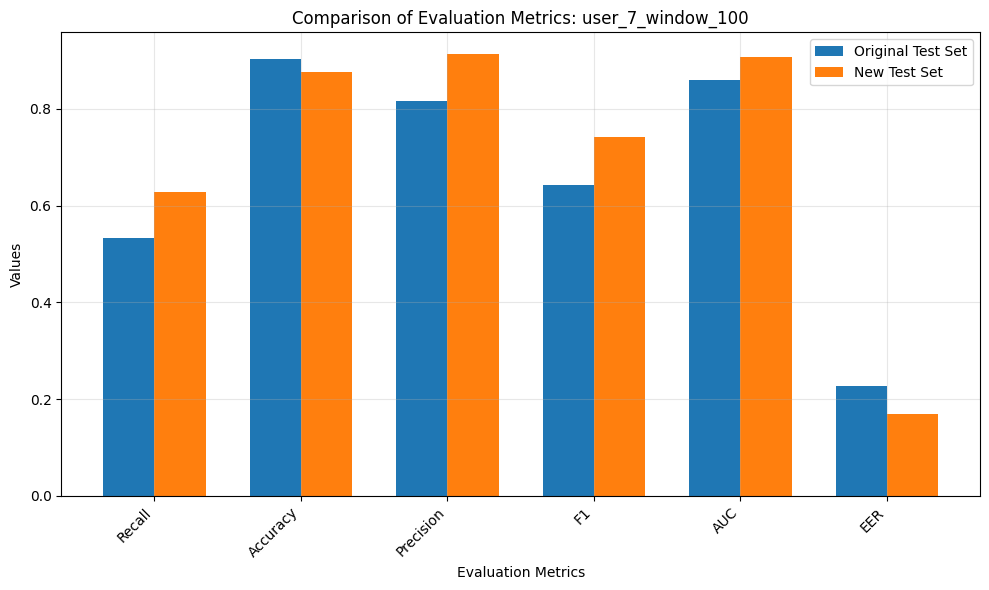

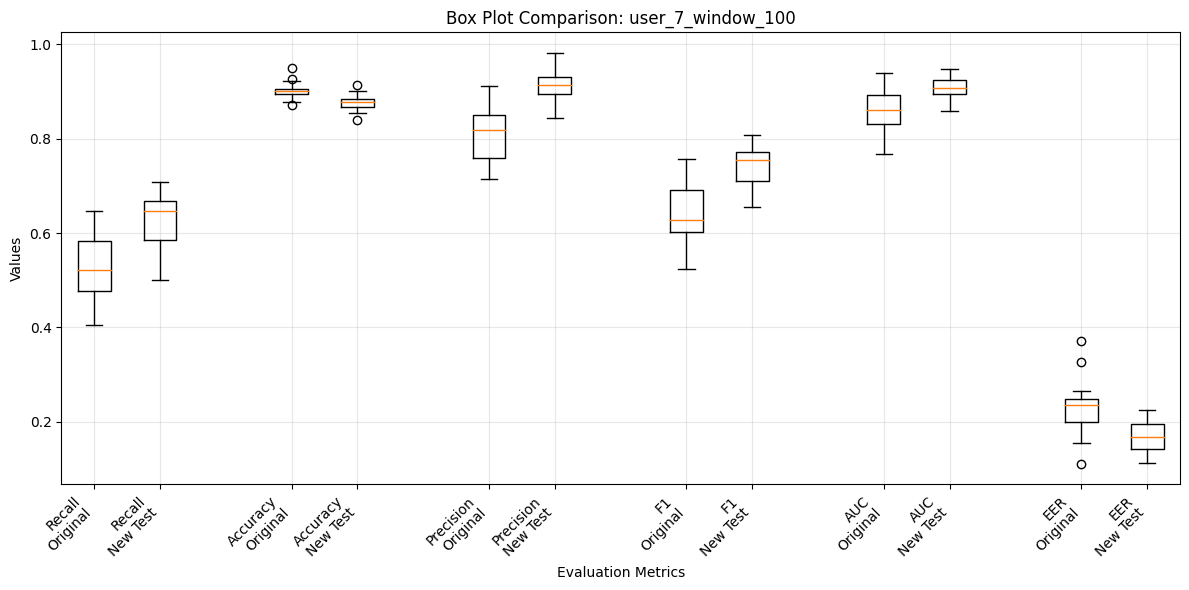

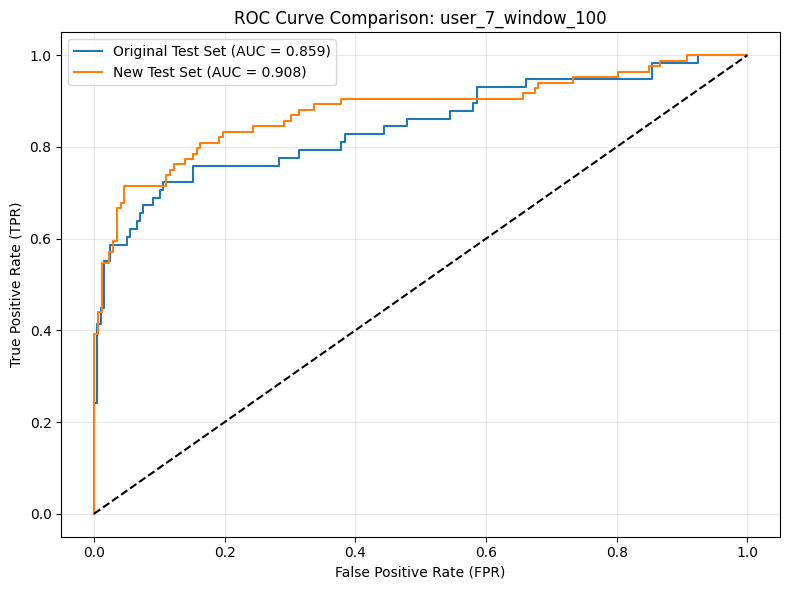

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
import numpy as np
import os
import torch

# 设置保存路径和用户信息
output_dir = "D:/论文数据/mouse/RESULTS/Plotting"
os.makedirs(output_dir, exist_ok=True)

# 准备数据
metrics_names = ['Recall', 'Accuracy', 'Precision', 'F1', 'AUC', 'EER']
original_values = [np.mean(d_c), np.mean(d_acc), np.mean(d_precision), 
                   np.mean(d_f1), np.mean(d_auc), np.mean(d_eer)]
new_values = [np.mean(d_c_2), np.mean(d_acc_2), np.mean(d_precision_2),
              np.mean(d_f1_2), np.mean(d_auc_2), np.mean(d_eer_2)]

# 1. 柱状图对比
plt.figure(figsize=(10, 6))
x = np.arange(len(metrics_names))
width = 0.35

plt.bar(x - width/2, original_values, width, label='Original Test Set')
plt.bar(x + width/2, new_values, width, label='New Test Set')

plt.xlabel('Evaluation Metrics')
plt.ylabel('Values')
plt.title(f'Comparison of Evaluation Metrics: user_{user_id}_window_{window_size}')
plt.xticks(x, metrics_names, rotation=45, ha='right')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

# 保存图片
bar_chart_path = os.path.join(output_dir, f"user_{user_id}_window_{window_size}_bar_chart.png")
plt.savefig(bar_chart_path)
plt.show()

# 2. 箱式图对比
plt.figure(figsize=(12, 6))
data = {
    'Recall': [d_c, d_c_2],
    'Accuracy': [d_acc, d_acc_2],
    'Precision': [d_precision, d_precision_2],
    'F1': [d_f1, d_f1_2],
    'AUC': [d_auc, d_auc_2],
    'EER': [d_eer, d_eer_2]
}

positions = []
labels = []
plot_data = []

for i, metric in enumerate(metrics_names):
    positions.extend([i*3, i*3 + 1])
    labels.extend([f'{metric}\nOriginal', f'{metric}\nNew Test'])
    plot_data.extend([data[metric][0], data[metric][1]])

plt.boxplot(plot_data, positions=positions)
plt.xticks(positions, labels, rotation=45, ha='right')
plt.xlabel('Evaluation Metrics')
plt.ylabel('Values')
plt.title(f'Box Plot Comparison: user_{user_id}_window_{window_size}')
plt.grid(True, alpha=0.3)
plt.tight_layout()

# 保存图片
box_plot_path = os.path.join(output_dir, f"user_{user_id}_window_{window_size}_box_plot.png")
plt.savefig(box_plot_path)
plt.show()

# 3. ROC曲线对比
plt.figure(figsize=(8, 6))

# 获取最后一个batch的ROC数据
with torch.no_grad():
    # 原始测试集
    inputs, labels = next(iter(X_test_loader))
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = New_model_new_test(inputs)
    if outputs.shape[1] == 1:
        pred_probs = torch.sigmoid(outputs).cpu().numpy()
        pred_probs = np.hstack([1 - pred_probs, pred_probs])
    else:
        pred_probs = torch.softmax(outputs, dim=1).cpu().numpy()
    labels_np = labels.cpu().numpy()
    fpr1, tpr1, _ = metrics.roc_curve(labels_np, pred_probs[:, 1])

    # 新测试集
    inputs, labels = next(iter(new_test_dataloader))
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = New_model_new_test(inputs)
    if outputs.shape[1] == 1:
        pred_probs = torch.sigmoid(outputs).cpu().numpy()
        pred_probs = np.hstack([1 - pred_probs, pred_probs])
    else:
        pred_probs = torch.softmax(outputs, dim=1).cpu().numpy()
    labels_np = labels.cpu().numpy()
    fpr2, tpr2, _ = metrics.roc_curve(labels_np, pred_probs[:, 1])

plt.plot(fpr1, tpr1, label=f'Original Test Set (AUC = {np.mean(d_auc):.3f})')
plt.plot(fpr2, tpr2, label=f'New Test Set (AUC = {np.mean(d_auc_2):.3f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title(f'ROC Curve Comparison: user_{user_id}_window_{window_size}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

# 保存图片
roc_curve_path = os.path.join(output_dir, f"user_{user_id}_window_{window_size}_roc_curve.png")
plt.savefig(roc_curve_path)
plt.show()
